In [1]:
import cv2
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split, cross_val_score, KFold,StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import time

In [2]:
def load_images_from_folder(folder, width = 614, height = 614, one_symbol = False):
    #width, height = 250, 250
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            if one_symbol:# one symbol
                img = img[0:570, 44:614] # remove extra part
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img_sq = generate_subimages(img) # conver one image into 16
                for i in img_sq:
                    images.append(i)
            else:# whole constellation
                img = cv2.resize(img, (width, height))
                images.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
    
    return np.array(images)

def generate_subimages(image):
    # Determine the square size
    square_size = image.shape[0] // 4  # Assuming 4x4 grid

    # Split the image into equal squares
    squares = []
    for i in range(4):
        for j in range(4):
            square = image[i * square_size: (i + 1) * square_size, j * square_size: (j + 1) * square_size]
            squares.append(square)

    return squares


def visualize_all(images):
    fig = plt.figure(figsize=(8, 8))
    columns = 10
    rows = 10
    for i in range(0, columns*rows):
        img = images[i]
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title('Image '+str(i+1), fontsize = 7, loc='center')
    plt.show()
    
def load_visualize(path, Name, visualize = False, one_symbol = False):
    images = load_images_from_folder(path, one_symbol = one_symbol)
    num_img = len(images)
    print('------------'+ Name +'---------------')
    print('Number of imges: ', num_img)
    img_shape = images[0].shape
    print('Image size: ', img_shape)
    if visualize:
        plt.imshow(images_norm1[0], cmap='gray')
        plt.axis('off')
        plt.show()
    
    return images, img_shape

def flatten_normalize(images, img_shape):
    num_images = len(images)
    images_flat = np.zeros(shape=(num_images, img_shape[0]*img_shape[1]))
    
    for i, img in enumerate(images):
        images_flat[i, :] = img.flatten()/255
        
    print(images_flat.shape)
    return images_flat

In [3]:
orig = False # True -> domain A with larger noise; False -> domain A with smaller noise
if orig: 
    print('OSNR for domain A: 25dB, OSNR for domain B: 40dB')
    path_norm1 = '/kaggle/input/nda-dataset/Dataset/16QAM_OSNR_25dB_ChSp_50GHz_TxPower_1dBm_NoJammingSignal'
    path_norm2 = '/kaggle/input/nda-dataset/Dataset/16QAM_OSNR_25dB_ChSp_50GHz_TxPower_1dBm_PwrDiff_0dB_Gap_50GHz'
    path_fault_50 = '/kaggle/input/nda-dataset/Dataset/16QAM_OSNR_25dB_ChSp_50GHz_TxPower_1dBm_PwrDiff_6dB_Gap_50GHz'
    path_fault_43 = '/kaggle/input/nda-dataset/Dataset/16QAM_OSNR_25dB_ChSp_50GHz_TxPower_1dBm_PwrDiff_3dB_Gap_43.75GHz'
    path_fault_37 = '/kaggle/input/nda-dataset/Dataset/16QAM_OSNR_25dB_ChSp_50GHz_TxPower_1dBm_PwrDiff_0dB_Gap_37.5GHz'

    # domain B (for TL)
    path_norm1_b =      '/kaggle/input/nda-dataset-tl/Data from another domain for Transfer Learning/16QAM_OSNR_40dB_ChSp_50GHz_TxPower_1dBm_NoJammingSignal'
    path_norm2_b =      '/kaggle/input/nda-dataset-tl/Data from another domain for Transfer Learning/16QAM_OSNR_40dB_ChSp_50GHz_TxPower_1dBm_PwrDiff_0dB_Gap_50GHz'
    path_fault_50_b =   '/kaggle/input/nda-dataset-tl/Data from another domain for Transfer Learning/16QAM_OSNR_40dB_ChSp_50GHz_TxPower_1dBm_PwrDiff_6dB_Gap_50GHz'
    path_fault_43_b =   '/kaggle/input/nda-dataset-tl/Data from another domain for Transfer Learning/16QAM_OSNR_40dB_ChSp_50GHz_TxPower_1dBm_PwrDiff_3dB_Gap_43.75GHz'
    path_fault_37_b =   '/kaggle/input/nda-dataset-tl/Data from another domain for Transfer Learning/16QAM_OSNR_40dB_ChSp_50GHz_TxPower_1dBm_PwrDiff_0dB_Gap_37.5GHz'
else:
    print('OSNR for domain A: 40dB, OSNR for domain B: 25dB')
    
    # domain B (for TL)
    path_norm1_b = '/kaggle/input/nda-dataset/Dataset/16QAM_OSNR_25dB_ChSp_50GHz_TxPower_1dBm_NoJammingSignal'
    path_norm2_b = '/kaggle/input/nda-dataset/Dataset/16QAM_OSNR_25dB_ChSp_50GHz_TxPower_1dBm_PwrDiff_0dB_Gap_50GHz'
    path_fault_50_b = '/kaggle/input/nda-dataset/Dataset/16QAM_OSNR_25dB_ChSp_50GHz_TxPower_1dBm_PwrDiff_6dB_Gap_50GHz'
    path_fault_43_b = '/kaggle/input/nda-dataset/Dataset/16QAM_OSNR_25dB_ChSp_50GHz_TxPower_1dBm_PwrDiff_3dB_Gap_43.75GHz'
    path_fault_37_b = '/kaggle/input/nda-dataset/Dataset/16QAM_OSNR_25dB_ChSp_50GHz_TxPower_1dBm_PwrDiff_0dB_Gap_37.5GHz'

    path_norm1 =      '/kaggle/input/nda-dataset-tl/Data from another domain for Transfer Learning/16QAM_OSNR_40dB_ChSp_50GHz_TxPower_1dBm_NoJammingSignal'
    path_norm2 =      '/kaggle/input/nda-dataset-tl/Data from another domain for Transfer Learning/16QAM_OSNR_40dB_ChSp_50GHz_TxPower_1dBm_PwrDiff_0dB_Gap_50GHz'
    path_fault_50 =   '/kaggle/input/nda-dataset-tl/Data from another domain for Transfer Learning/16QAM_OSNR_40dB_ChSp_50GHz_TxPower_1dBm_PwrDiff_6dB_Gap_50GHz'
    path_fault_43 =   '/kaggle/input/nda-dataset-tl/Data from another domain for Transfer Learning/16QAM_OSNR_40dB_ChSp_50GHz_TxPower_1dBm_PwrDiff_3dB_Gap_43.75GHz'
    path_fault_37 =   '/kaggle/input/nda-dataset-tl/Data from another domain for Transfer Learning/16QAM_OSNR_40dB_ChSp_50GHz_TxPower_1dBm_PwrDiff_0dB_Gap_37.5GHz'

OSNR for domain A: 40dB, OSNR for domain B: 25dB


In [4]:
images_norm1, img_shape = load_visualize(path_norm1, 'Normal1')
images_norm2, _ = load_visualize(path_norm2, 'Normal2')

images_fault_50, _ = load_visualize(path_fault_50, 'Faulty1')
images_fault_43, _ = load_visualize(path_fault_43, 'Faulty2')
images_fault_37, _ = load_visualize(path_fault_37, 'Faulty3')

------------Normal1---------------
Number of imges:  100
Image size:  (614, 614)
------------Normal2---------------
Number of imges:  100
Image size:  (614, 614)
------------Faulty1---------------
Number of imges:  100
Image size:  (614, 614)
------------Faulty2---------------
Number of imges:  100
Image size:  (614, 614)
------------Faulty3---------------
Number of imges:  100
Image size:  (614, 614)


In [5]:
visualize = False
if visualize:
    visualize_all(images_norm1)
    visualize_all(images_norm2)
    
    visualize_all(images_fault_50)
    visualize_all(images_fault_43)
    visualize_all(images_fault_37)

# 1a) Original images

In [6]:
# flatten each image
norm1_flat = flatten_normalize(images_norm1, img_shape)
norm2_flat = flatten_normalize(images_norm2, img_shape)

fault1_flat = flatten_normalize(images_fault_50, img_shape)
fault2_flat = flatten_normalize(images_fault_43, img_shape)
fault3_flat = flatten_normalize(images_fault_37, img_shape)

(100, 376996)
(100, 376996)
(100, 376996)
(100, 376996)
(100, 376996)


In [7]:
def Train_test_val_split(norm1_flat, norm2_flat, fault1_flat, fault2_flat, fault3_flat, use_pca = False):
    normal = np.vstack((norm1_flat, norm2_flat)) # stack good classes 
    labels_normal = np.ones(shape = normal.shape[0])

    faulty = np.vstack((fault1_flat, fault2_flat, fault3_flat)) # stack good classes 
    labels_faulty = -1 * np.ones(shape = faulty.shape[0])


    normal_train, normal_test, labels_normal_train, labels_normal_test = train_test_split(normal, labels_normal, test_size=0.2, random_state=42)
    X_train, y_train = normal_train, labels_normal_train
    X_test, y_test = np.vstack((normal_test, faulty)), np.concatenate((labels_normal_test, labels_faulty))

    if use_pca:
        pca = PCA()
        X_train = pca.fit_transform(X_train)
        X_train_explained_variances = pca.explained_variance_ratio_
        print('Explained variance percentage =', sum(X_train_explained_variances))
        
        X_test = pca.transform(X_test)
        X_test_explained_variances = pca.explained_variance_ratio_
        
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        plt.subplots_adjust(wspace=0.5, hspace=0.5)
        
        axes[0].plot(range(1,len(X_train_explained_variances)+1), np.cumsum(X_train_explained_variances * 100))
        axes[0].set_xlabel('Number of components')
        axes[0].set_ylabel('Per-component explained variance (%)')
        axes[0].grid()
        axes[0].set_title("X_train")
        
        axes[1].plot(range(1,len(X_test_explained_variances)+1), np.cumsum(X_train_explained_variances * 100))
        axes[1].set_xlabel('Number of components')
        axes[1].set_ylabel('Per-component explained variance (%)')
        axes[1].grid()
        axes[1].set_title("X_test")
        fig.tight_layout()

    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, stratify=y_test, test_size=0.2, random_state=42)
    print('The number of records in the training dataset is', X_train.shape[0],'#-1:', np.where(y_train == -1)[0].shape[0],' #1:', np.where(y_train == 1)[0].shape[0]) 
    print('The number of records in the validation dataset is', X_val.shape[0],'#-1:', np.where(y_val == -1)[0].shape[0],' #1:', np.where(y_val == 1)[0].shape[0]) 
    print('The number of records in the testing dataset is', X_test.shape[0],'#-1:', np.where(y_test == -1)[0].shape[0],' #1:', np.where(y_test == 1)[0].shape[0])
    
    return X_train, X_val, X_test, y_train, y_val, y_test 

In [8]:
X_train, X_val, X_test, y_train, y_val, y_test  = Train_test_val_split(norm1_flat, norm2_flat, fault1_flat, fault2_flat, fault3_flat)

The number of records in the training dataset is 160 #-1: 0  #1: 160
The number of records in the validation dataset is 272 #-1: 240  #1: 32
The number of records in the testing dataset is 68 #-1: 60  #1: 8


In [9]:
def CV_one_class_svm(X_train, y_train, X_val, y_val, K):
    n_split_kfold = K
    skf = KFold(n_splits=n_split_kfold, shuffle=True, random_state=3)

    best_params = {'nu': 0, 'kernel': 0, 'gamma':0, 'score': 0}
    nu_range = [0.01, 0.2, 0.7]
    kernel_range = ['rbf', 'sigmoid', 'linear']
    gamma_range = ['scale', 'auto']

    t0 = time.time() 
    
    best_stat = []
    for i, nu in enumerate(nu_range): #loop over regularization parameter
        for j, kernel in enumerate(kernel_range): #loop over maximum iterations
            for k, gamma in enumerate(gamma_range):
                print(f'Testing hyperparameters: nu: {nu}, kernel: {kernel}, gamma: {gamma}')
                stat = []
                for (train_index, val_index1), (_, val_index2) in zip(skf.split(X_train, y_train), skf.split(X_val, y_val)):
                    X_train_fold, X_test_fold = X_train[train_index], np.vstack((X_val[val_index2], X_train[val_index1]))
                    y_train_fold, y_test_fold = y_train[train_index], np.concatenate((y_val[val_index2], y_train[val_index1]))

                    one_class_svm =  OneClassSVM(nu=nu, kernel = kernel, gamma = gamma)
                    one_class_svm.fit(X_train_fold)
                    pred = one_class_svm.predict(X_test_fold)
                    stat.append(sum(pred == y_test_fold)/y_test_fold.shape[0])

                score = sum(stat) / n_split_kfold
                print('score', score)
                if score > best_params['score']:
                    best_params['score'] = score
                    best_params['nu'] = nu
                    best_params['kernel'] = kernel
                    best_params['gamma'] = gamma
                    best_stat = stat
                    #print('New best hyperparameters!!')
    t1 = time.time()
    crossval_time = round(t1-t0,3)            
    print('Crossval time',time.strftime("%H:%M:%S", time.gmtime(crossval_time)))
    print('Best hyperparams during crossval: ' + str(best_params))


    best_one_class_svm =OneClassSVM(nu=best_params['nu'], kernel = best_params['kernel'], gamma = best_params['gamma'])
    t0 = time.time()
    best_one_class_svm.fit(X_train, y_train) 
    t1 = time.time()
    training_time = round(t1-t0,3)
    final_pred = best_one_class_svm.predict(X_val)
    finalscore = sum(final_pred == y_val)/y_val.shape[0]
    print('Accuracy of the final model on validation: ' + str(finalscore))
    print('Training time',time.strftime("%H:%M:%S", time.gmtime(training_time)))
    
    
    cm = confusion_matrix(y_val, final_pred)#, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)#,
                                  #display_labels=clf.classes_)
    disp.plot()
    plt.show()
    
    return best_one_class_svm, best_params, best_stat



def CV_train_isolation_forest(X_train, y_train, X_val, y_val, K):
    n_split_kfold = K
    skf = KFold(n_splits=n_split_kfold, shuffle=True, random_state=3)

    best_params = {'n_estimators': 0, 'max_samples_range': 0, 'contamination': 0, 'score': 0}
    n_estimators_range = [50, 75, 100]
    max_samples_range = [10, 50, 100]
    contamination_range = [0.1, 0.3]

    t0 = time.time() 
    
    best_stat = []
    for i, n_estimators in enumerate(n_estimators_range): 
        for j, max_samples in enumerate(max_samples_range): #loop over maximum iterations
            for k, contamination in enumerate(contamination_range):
                    print(f'Testing hyperparameters: n_estimators: {n_estimators}, max_samples: {max_samples}, contamination: {contamination}')
                    stats = []
                    for (train_index, val_index1), (_, val_index2) in zip(skf.split(X_train, y_train), skf.split(X_val, y_val)):
                        X_train_fold, X_test_fold = X_train[train_index], np.vstack((X_val[val_index2], X_train[val_index1]))
                        y_train_fold, y_test_fold = y_train[train_index], np.concatenate((y_val[val_index2], y_train[val_index1]))

                        isol_forest=IsolationForest(n_estimators=n_estimators, max_samples=max_samples, contamination=contamination)
                        isol_forest.fit(X_train_fold)
                        pred = isol_forest.predict(X_test_fold)
                        stats.append(sum(pred == y_test_fold)/y_test_fold.shape[0])

                    score = sum(stats) / n_split_kfold
                    print('score', score)
                    if score > best_params['score']:
                        best_params['score'] = score
                        best_params['n_estimators'] = n_estimators
                        best_params['max_samples'] = max_samples
                        best_params['contamination'] = contamination
                        best_stat = stats
    t1 = time.time()
    crossval_time = round(t1-t0,3)            
    print('Crossval time',time.strftime("%H:%M:%S", time.gmtime(crossval_time)))
    print('Best hyperparams during crossval: ' + str(best_params))


    best_isol_forest=IsolationForest(n_estimators=best_params['n_estimators'], max_samples=best_params['max_samples'], 
                                contamination=best_params['contamination'])
    t0 = time.time()
    best_isol_forest.fit(X_train) 
    t1 = time.time()
    training_time = round(t1-t0,3)
    final_pred = best_isol_forest.predict(X_val)
    finalscore = sum(final_pred == y_val)/y_val.shape[0]
    print('Accuracy of the final model on validation: ' + str(finalscore))
    print('Training time',time.strftime("%H:%M:%S", time.gmtime(training_time)))
   
    
    cm = confusion_matrix(y_val, final_pred)#, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)#,
                                  #display_labels=clf.classes_)
    disp.plot()
    plt.show()
    
    return best_isol_forest, best_params, best_stat

In [10]:
def evaluate_model(model, X_test, y_test , return_list=False):
    # Test
    prediction = model.predict(X_test)

    accuracy = accuracy_score(y_test, prediction)
    report = classification_report(y_test, prediction, output_dict=True)

    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1_score = report['weighted avg']['f1-score']
    
    print("Test Accuracy:", accuracy)
    print("Test classification report:")
    print(classification_report(y_test, prediction))

    cm = confusion_matrix(y_test, prediction)#, labels=clf.classes_)

    class_labels = ['-1' , '1']
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot()
    plt.show()
    
    if return_list == False:
        return accuracy, precision, recall, f1_score
    if return_list == True:
        return [accuracy, precision, recall, f1_score]


Testing hyperparameters: nu: 0.01, kernel: rbf, gamma: scale
score 0.8795241913926757
Testing hyperparameters: nu: 0.01, kernel: rbf, gamma: auto
score 0.9026730820636193
Testing hyperparameters: nu: 0.01, kernel: sigmoid, gamma: scale
score 0.7081529002940391
Testing hyperparameters: nu: 0.01, kernel: sigmoid, gamma: auto
score 0.983827853515103
Testing hyperparameters: nu: 0.01, kernel: linear, gamma: scale
score 0.983827853515103
Testing hyperparameters: nu: 0.01, kernel: linear, gamma: auto
score 0.983827853515103
Testing hyperparameters: nu: 0.2, kernel: rbf, gamma: scale
score 0.8470462443197005
Testing hyperparameters: nu: 0.2, kernel: rbf, gamma: auto
score 0.8609997326917934
Testing hyperparameters: nu: 0.2, kernel: sigmoid, gamma: scale
score 0.8330927559476076
Testing hyperparameters: nu: 0.2, kernel: sigmoid, gamma: auto
score 0.9073777064955892
Testing hyperparameters: nu: 0.2, kernel: linear, gamma: scale
score 0.9073777064955892
Testing hyperparameters: nu: 0.2, kernel: 

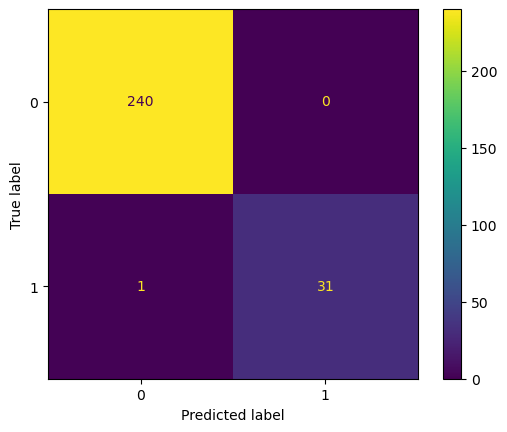

Average K-fold accuracy: 0.983827853515103 +- 0.009222714205976076
Test Accuracy: 1.0
Test classification report:
              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00        60
         1.0       1.00      1.00      1.00         8

    accuracy                           1.00        68
   macro avg       1.00      1.00      1.00        68
weighted avg       1.00      1.00      1.00        68



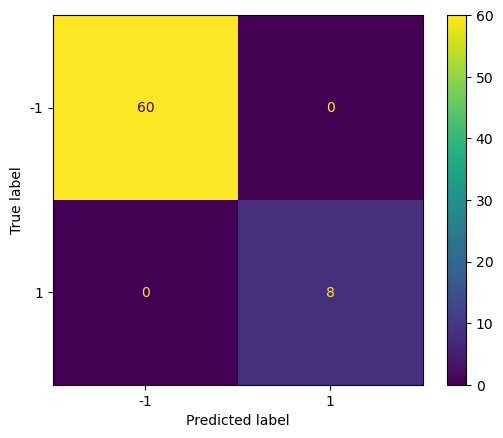

In [11]:
# OC_SVM
# val
one_class_svm_A, one_class_svm_params_A, stat = CV_one_class_svm(X_train, y_train, X_val, y_val, 5)
print('Average K-fold accuracy:', np.mean(stat),'+-', np.std(stat))

acc_oc_svm_A, precision_oc_svm_A, recall_oc_svm_A, f1_oc_svm_A = evaluate_model(one_class_svm_A, X_test, y_test)

Testing hyperparameters: n_estimators: 50, max_samples: 10, contamination: 0.1
score 0.9444800855386261
Testing hyperparameters: n_estimators: 50, max_samples: 10, contamination: 0.3
score 0.8635124298315958
Testing hyperparameters: n_estimators: 50, max_samples: 50, contamination: 0.1
score 0.9582999198075381
Testing hyperparameters: n_estimators: 50, max_samples: 50, contamination: 0.3
score 0.870462443197006
Testing hyperparameters: n_estimators: 50, max_samples: 100, contamination: 0.1
score 0.9491312483293237
Testing hyperparameters: n_estimators: 50, max_samples: 100, contamination: 0.3
score 0.872654370489174
Testing hyperparameters: n_estimators: 75, max_samples: 10, contamination: 0.1
score 0.9583533814488104
Testing hyperparameters: n_estimators: 75, max_samples: 10, contamination: 0.3
score 0.8632718524458701
Testing hyperparameters: n_estimators: 75, max_samples: 50, contamination: 0.1
score 0.9583533814488104
Testing hyperparameters: n_estimators: 75, max_samples: 50, cont

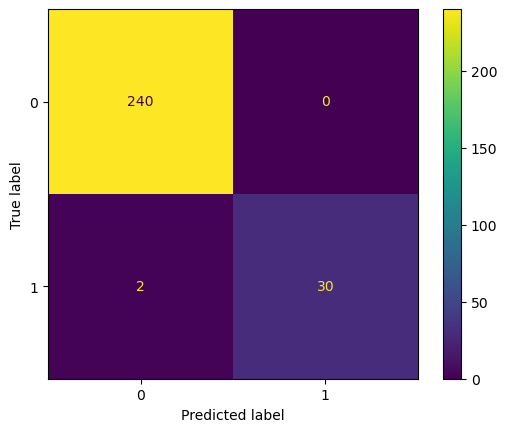

Average K-fold accuracy: 0.9722801390002672 +- 0.011643596907753592
Test Accuracy: 1.0
Test classification report:
              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00        60
         1.0       1.00      1.00      1.00         8

    accuracy                           1.00        68
   macro avg       1.00      1.00      1.00        68
weighted avg       1.00      1.00      1.00        68



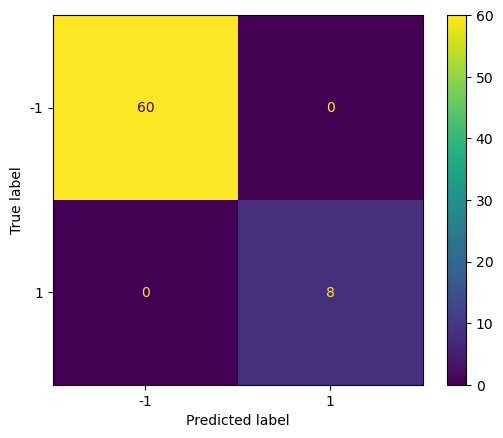

In [12]:
# IF
# val
isol_forest_A, isol_forest_params_A, stat = CV_train_isolation_forest(X_train, y_train, X_val, y_val, 5)
print('Average K-fold accuracy:', np.mean(stat),'+-', np.std(stat))

acc_isol_forest_A, precision_isol_forest_A, recall_isol_forest_A, f1_isol_forest_A = evaluate_model(isol_forest_A, X_test, y_test)

# 1b) Original images + PCA

Explained variance percentage = 1.0000000000000004
The number of records in the training dataset is 160 #-1: 0  #1: 160
The number of records in the validation dataset is 272 #-1: 240  #1: 32
The number of records in the testing dataset is 68 #-1: 60  #1: 8


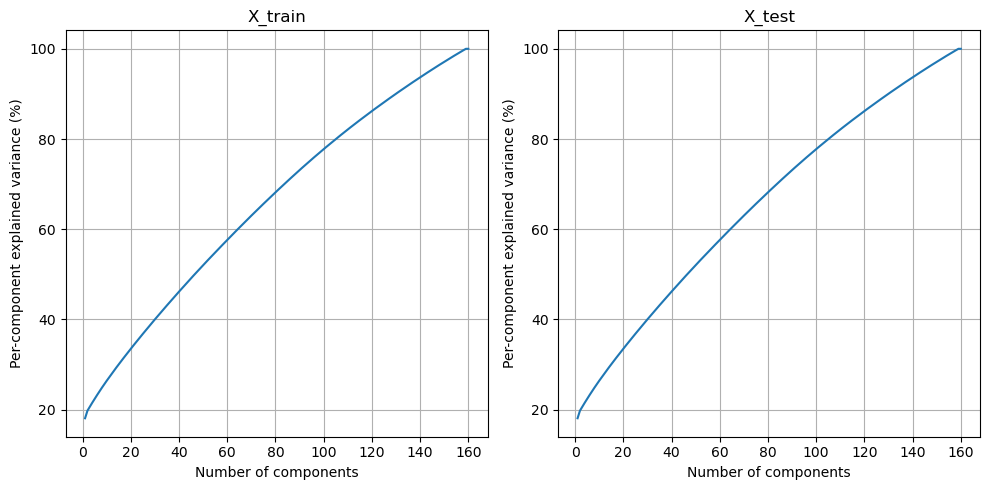

In [13]:
X_train, X_val, X_test, y_train, y_val, y_test  = Train_test_val_split(norm1_flat, norm2_flat, fault1_flat, fault2_flat, fault3_flat, use_pca = True)

Testing hyperparameters: nu: 0.01, kernel: rbf, gamma: scale
score 0.6087409783480353
Testing hyperparameters: nu: 0.01, kernel: rbf, gamma: auto
score 0.5555199144613739
Testing hyperparameters: nu: 0.01, kernel: sigmoid, gamma: scale
score 0.634242181234964
Testing hyperparameters: nu: 0.01, kernel: sigmoid, gamma: auto
score 0.6479818230419674
Testing hyperparameters: nu: 0.01, kernel: linear, gamma: scale
score 0.46947340283346695
Testing hyperparameters: nu: 0.01, kernel: linear, gamma: auto
score 0.46947340283346695
Testing hyperparameters: nu: 0.2, kernel: rbf, gamma: scale
score 0.7059877038225073
Testing hyperparameters: nu: 0.2, kernel: rbf, gamma: auto
score 0.5555199144613739
Testing hyperparameters: nu: 0.2, kernel: sigmoid, gamma: scale
score 0.6018711574445336
Testing hyperparameters: nu: 0.2, kernel: sigmoid, gamma: auto
score 0.9257952419139267
Testing hyperparameters: nu: 0.2, kernel: linear, gamma: scale
score 0.46947340283346695
Testing hyperparameters: nu: 0.2, ker

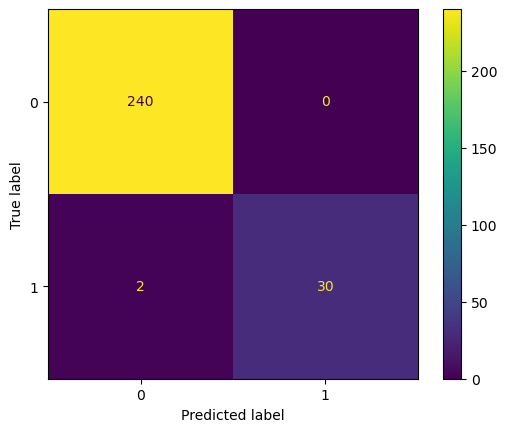

Average K-fold accuracy: 0.9257952419139267 +- 0.02731850635634564
Test Accuracy: 1.0
Test classification report:
              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00        60
         1.0       1.00      1.00      1.00         8

    accuracy                           1.00        68
   macro avg       1.00      1.00      1.00        68
weighted avg       1.00      1.00      1.00        68



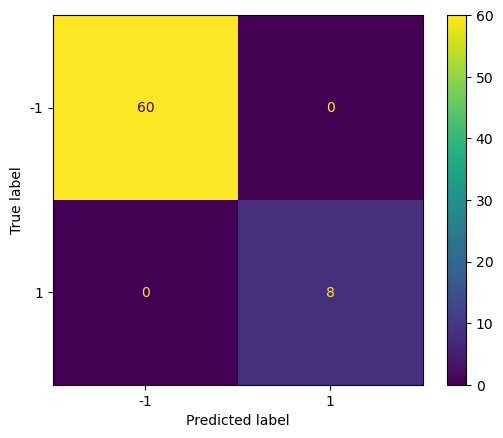

In [14]:
# OC_SVM
# val
one_class_svm, one_class_svm_params, stat = CV_one_class_svm(X_train, y_train, X_val, y_val, 5)
print('Average K-fold accuracy:', np.mean(stat),'+-', np.std(stat))

acc_one_class_svm_pca, precision_one_class_svm_pca, recall_one_class_svm_pca, f1_one_class_svm_pca = evaluate_model(one_class_svm, X_test, y_test)

Testing hyperparameters: n_estimators: 50, max_samples: 10, contamination: 0.1
score 0.407457898957498
Testing hyperparameters: n_estimators: 50, max_samples: 10, contamination: 0.3
score 0.3055600106923283
Testing hyperparameters: n_estimators: 50, max_samples: 50, contamination: 0.1
score 0.3937182571504945
Testing hyperparameters: n_estimators: 50, max_samples: 50, contamination: 0.3
score 0.3287890938251804
Testing hyperparameters: n_estimators: 50, max_samples: 100, contamination: 0.1
score 0.37968457631649294
Testing hyperparameters: n_estimators: 50, max_samples: 100, contamination: 0.3
score 0.34493450948944127
Testing hyperparameters: n_estimators: 75, max_samples: 10, contamination: 0.1
score 0.4236033146217588
Testing hyperparameters: n_estimators: 75, max_samples: 10, contamination: 0.3
score 0.31724137931034485
Testing hyperparameters: n_estimators: 75, max_samples: 50, contamination: 0.1
score 0.4052125100240578
Testing hyperparameters: n_estimators: 75, max_samples: 50, 

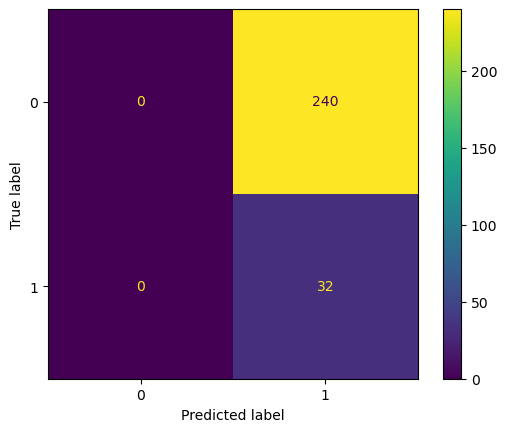

Average K-fold accuracy: 0.4236033146217588 +- 0.025767679207851172
Test Accuracy: 0.11764705882352941
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00        60
         1.0       0.12      1.00      0.21         8

    accuracy                           0.12        68
   macro avg       0.06      0.50      0.11        68
weighted avg       0.01      0.12      0.02        68



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

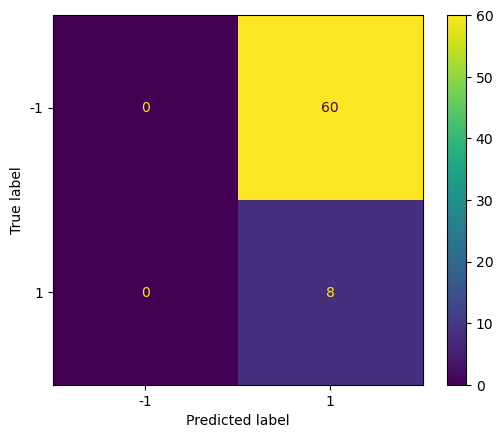

In [15]:
# IF
# val
isol_forest, isol_forest_params, stat = CV_train_isolation_forest(X_train, y_train, X_val, y_val, 5)
print('Average K-fold accuracy:', np.mean(stat),'+-', np.std(stat))

acc_isol_forest_pca, precision_isol_forest_pca, recall_isol_forest_pca, f1_isol_forest_pca = evaluate_model(isol_forest, X_test, y_test)

# 2a) Resized images

In [16]:
images_norm1 = load_images_from_folder(path_norm1, 250, 250)
images_norm2 = load_images_from_folder(path_norm2, 250, 250)

images_fault_50 = load_images_from_folder(path_fault_50, 250, 250)
images_fault_43 = load_images_from_folder(path_fault_43, 250, 250)
images_fault_37 = load_images_from_folder(path_fault_37, 250, 250)

In [17]:
# flatten each image
img_shape = images_norm1[0].shape
norm1_flat = flatten_normalize(images_norm1, img_shape)
norm2_flat = flatten_normalize(images_norm2, img_shape)

fault1_flat = flatten_normalize(images_fault_50, img_shape)
fault2_flat = flatten_normalize(images_fault_43, img_shape)
fault3_flat = flatten_normalize(images_fault_37, img_shape)

(100, 62500)
(100, 62500)
(100, 62500)
(100, 62500)
(100, 62500)


In [18]:
X_train, X_val, X_test, y_train, y_val, y_test  = Train_test_val_split(norm1_flat, norm2_flat, fault1_flat, fault2_flat, fault3_flat)

The number of records in the training dataset is 160 #-1: 0  #1: 160
The number of records in the validation dataset is 272 #-1: 240  #1: 32
The number of records in the testing dataset is 68 #-1: 60  #1: 8


Testing hyperparameters: nu: 0.01, kernel: rbf, gamma: scale
score 0.8887730553327986
Testing hyperparameters: nu: 0.01, kernel: rbf, gamma: auto
score 0.9095963646083934
Testing hyperparameters: nu: 0.01, kernel: sigmoid, gamma: scale
score 0.7104784816893879
Testing hyperparameters: nu: 0.01, kernel: sigmoid, gamma: auto
score 0.9861534349104517
Testing hyperparameters: nu: 0.01, kernel: linear, gamma: scale
score 0.9861534349104517
Testing hyperparameters: nu: 0.01, kernel: linear, gamma: auto
score 0.9861534349104517
Testing hyperparameters: nu: 0.2, kernel: rbf, gamma: scale
score 0.856348569901096
Testing hyperparameters: nu: 0.2, kernel: rbf, gamma: auto
score 0.8679497460572039
Testing hyperparameters: nu: 0.2, kernel: sigmoid, gamma: scale
score 0.8105854049719327
Testing hyperparameters: nu: 0.2, kernel: sigmoid, gamma: auto
score 0.9097032878909381
Testing hyperparameters: nu: 0.2, kernel: linear, gamma: scale
score 0.9097032878909381
Testing hyperparameters: nu: 0.2, kernel

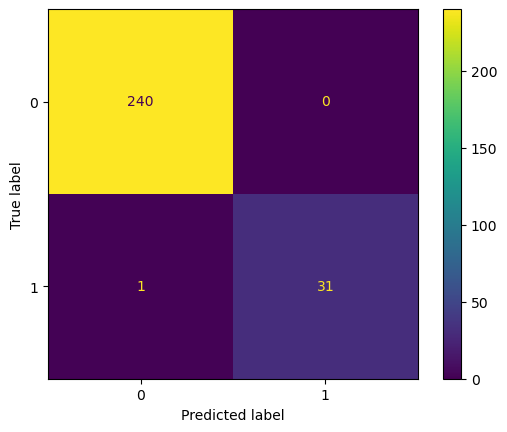

Average K-fold accuracy: 0.9861534349104517 +- 0.008587460746873663
Test Accuracy: 1.0
Test classification report:
              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00        60
         1.0       1.00      1.00      1.00         8

    accuracy                           1.00        68
   macro avg       1.00      1.00      1.00        68
weighted avg       1.00      1.00      1.00        68



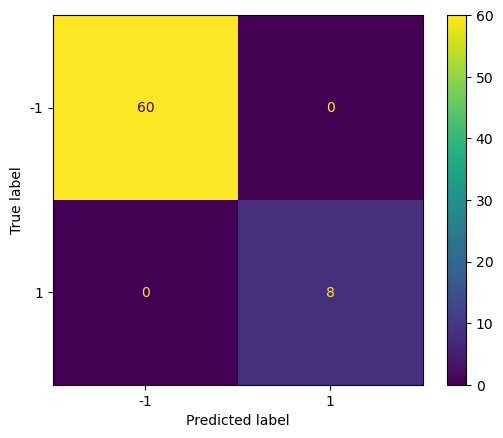

In [19]:
# OC_SVM
# val
one_class_svm, one_class_svm_params, stat = CV_one_class_svm(X_train, y_train, X_val, y_val, 5)
print('Average K-fold accuracy:', np.mean(stat),'+-', np.std(stat))

acc_one_class_svm_resize, precision_one_class_svm_resize, recall_one_class_svm_resize, f1_one_class_svm_resize = evaluate_model(one_class_svm, X_test, y_test)

Testing hyperparameters: n_estimators: 50, max_samples: 10, contamination: 0.1
score 0.9653568564554931
Testing hyperparameters: n_estimators: 50, max_samples: 10, contamination: 0.3
score 0.8657043571237637
Testing hyperparameters: n_estimators: 50, max_samples: 50, contamination: 0.1
score 0.9584068430900828
Testing hyperparameters: n_estimators: 50, max_samples: 50, contamination: 0.3
score 0.8867949746057203
Testing hyperparameters: n_estimators: 50, max_samples: 100, contamination: 0.1
score 0.9607056936647954
Testing hyperparameters: n_estimators: 50, max_samples: 100, contamination: 0.3
score 0.8448543170275327
Testing hyperparameters: n_estimators: 75, max_samples: 10, contamination: 0.1
score 0.9630045442395081
Testing hyperparameters: n_estimators: 75, max_samples: 10, contamination: 0.3
score 0.8632985832665062
Testing hyperparameters: n_estimators: 75, max_samples: 50, contamination: 0.1
score 0.9630312750601444
Testing hyperparameters: n_estimators: 75, max_samples: 50, co

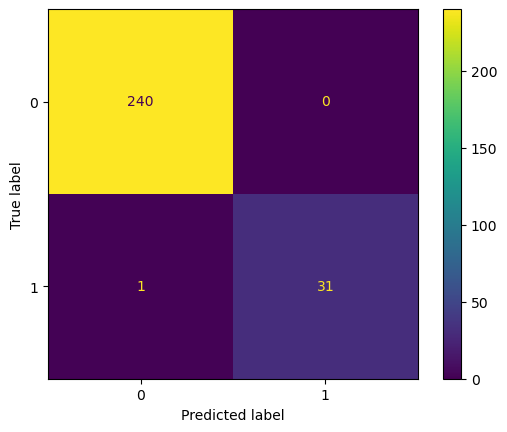

Average K-fold accuracy: 0.9653568564554931 +- 0.016180296227133628
Test Accuracy: 1.0
Test classification report:
              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00        60
         1.0       1.00      1.00      1.00         8

    accuracy                           1.00        68
   macro avg       1.00      1.00      1.00        68
weighted avg       1.00      1.00      1.00        68



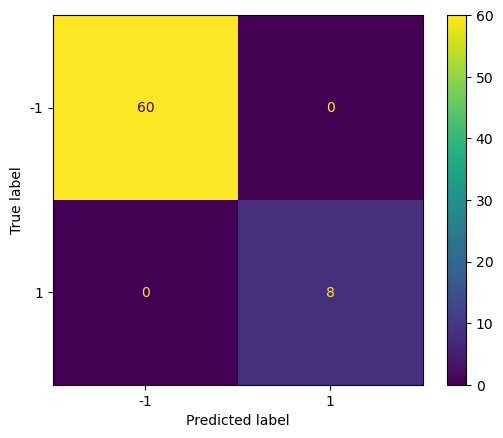

In [20]:
# IF
# val
isol_forest, isol_forest_params, stat = CV_train_isolation_forest(X_train, y_train, X_val, y_val, 5)
print('Average K-fold accuracy:', np.mean(stat),'+-', np.std(stat))

acc_isol_forest_resize, precision_isol_forest_resize, recall_isol_forest_resize, f1_isol_forest_resize = evaluate_model(isol_forest, X_test, y_test)

# 2b) Resized images + PCA

Explained variance percentage = 1.0000000000000002
The number of records in the training dataset is 160 #-1: 0  #1: 160
The number of records in the validation dataset is 272 #-1: 240  #1: 32
The number of records in the testing dataset is 68 #-1: 60  #1: 8


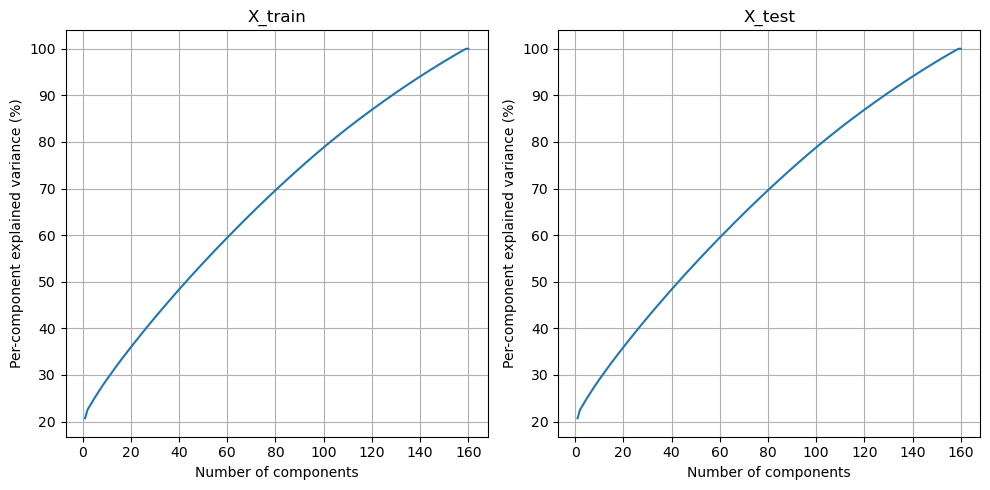

In [21]:
X_train, X_val, X_test, y_train, y_val, y_test  = Train_test_val_split(norm1_flat, norm2_flat, fault1_flat, fault2_flat, fault3_flat, use_pca = True)

Testing hyperparameters: nu: 0.01, kernel: rbf, gamma: scale
score 0.6734562951082598
Testing hyperparameters: nu: 0.01, kernel: rbf, gamma: auto
score 0.5555199144613739
Testing hyperparameters: nu: 0.01, kernel: sigmoid, gamma: scale
score 0.7083934776797648
Testing hyperparameters: nu: 0.01, kernel: sigmoid, gamma: auto
score 0.8513231756214916
Testing hyperparameters: nu: 0.01, kernel: linear, gamma: scale
score 0.45319433306602513
Testing hyperparameters: nu: 0.01, kernel: linear, gamma: auto
score 0.45319433306602513
Testing hyperparameters: nu: 0.2, kernel: rbf, gamma: scale
score 0.7036888532477946
Testing hyperparameters: nu: 0.2, kernel: rbf, gamma: auto
score 0.5555199144613739
Testing hyperparameters: nu: 0.2, kernel: sigmoid, gamma: scale
score 0.620449077786688
Testing hyperparameters: nu: 0.2, kernel: sigmoid, gamma: auto
score 0.34717989842288166
Testing hyperparameters: nu: 0.2, kernel: linear, gamma: scale
score 0.45319433306602513
Testing hyperparameters: nu: 0.2, ke

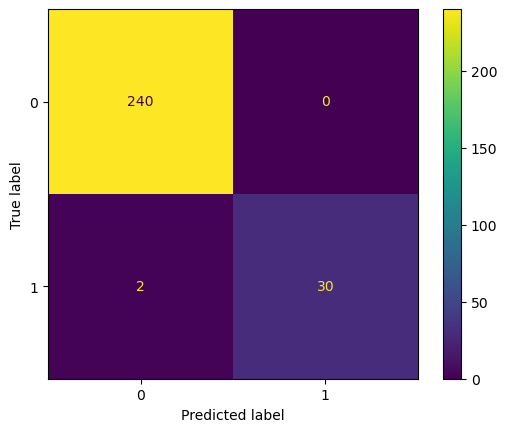

Average K-fold accuracy: 0.8513231756214916 +- 0.24557485186681438
Test Accuracy: 1.0
Test classification report:
              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00        60
         1.0       1.00      1.00      1.00         8

    accuracy                           1.00        68
   macro avg       1.00      1.00      1.00        68
weighted avg       1.00      1.00      1.00        68



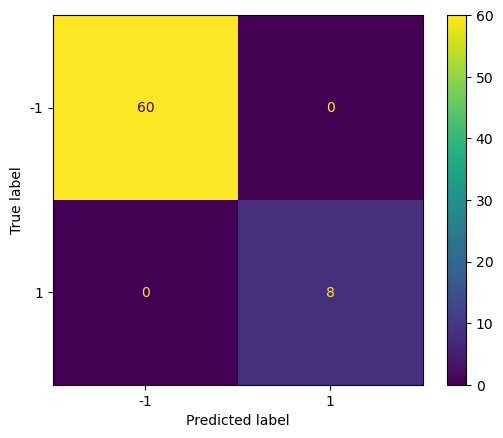

In [22]:
# OC_SVM
# val
one_class_svm, one_class_svm_params, stat = CV_one_class_svm(X_train, y_train, X_val, y_val, 5)
print('Average K-fold accuracy:', np.mean(stat),'+-', np.std(stat))

acc_one_class_svm_resize_pca, precision_one_class_svm_resize_pca, recall_one_class_svm_resize_pca, f1_one_class_svm_resize_pca = evaluate_model(one_class_svm, X_test, y_test)

Testing hyperparameters: n_estimators: 50, max_samples: 10, contamination: 0.1
score 0.4167334937182571
Testing hyperparameters: n_estimators: 50, max_samples: 10, contamination: 0.3
score 0.35891472868217056
Testing hyperparameters: n_estimators: 50, max_samples: 50, contamination: 0.1
score 0.39818230419673883
Testing hyperparameters: n_estimators: 50, max_samples: 50, contamination: 0.3
score 0.3195402298850575
Testing hyperparameters: n_estimators: 50, max_samples: 100, contamination: 0.1
score 0.3889067094359797
Testing hyperparameters: n_estimators: 50, max_samples: 100, contamination: 0.3
score 0.31724137931034485
Testing hyperparameters: n_estimators: 75, max_samples: 10, contamination: 0.1
score 0.3980486500935579
Testing hyperparameters: n_estimators: 75, max_samples: 10, contamination: 0.3
score 0.3333867949746057
Testing hyperparameters: n_estimators: 75, max_samples: 50, contamination: 0.1
score 0.3912590216519647
Testing hyperparameters: n_estimators: 75, max_samples: 50,

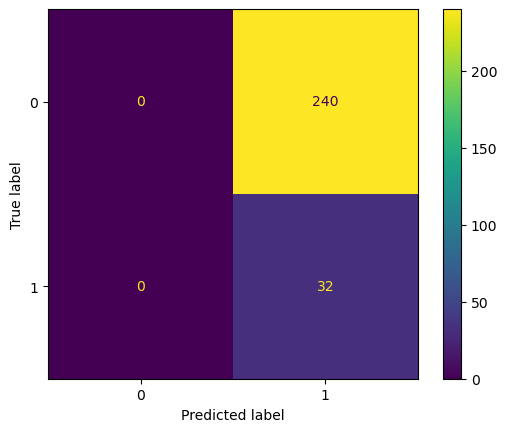

Average K-fold accuracy: 0.4237102379043036 +- 0.04186889659498848
Test Accuracy: 0.11764705882352941
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00        60
         1.0       0.12      1.00      0.21         8

    accuracy                           0.12        68
   macro avg       0.06      0.50      0.11        68
weighted avg       0.01      0.12      0.02        68



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

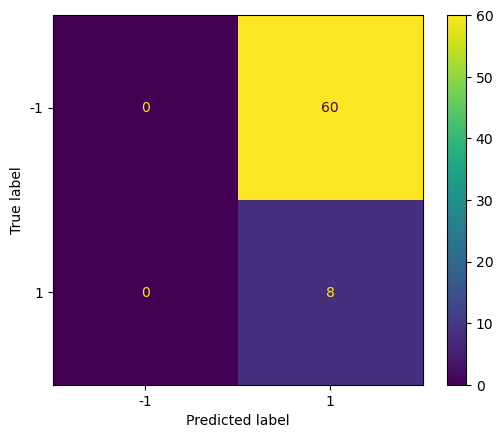

In [23]:
# IF
# val
isol_forest, isol_forest_params, stat = CV_train_isolation_forest(X_train, y_train, X_val, y_val, 5)
print('Average K-fold accuracy:', np.mean(stat),'+-', np.std(stat))

acc_isol_forest_resize_pca, precision_isol_forest_resize_pca, recall_isol_forest_resize_pca, f1_isol_forest_resize_pca = evaluate_model(isol_forest, X_test, y_test)

# 3a) Transfer learning - original images

In [24]:
# DOMAIN A
images_norm1, img_shape = load_visualize(path_norm1, 'Normal1')
images_norm2, _ = load_visualize(path_norm2, 'Normal2')

images_fault_50, _ = load_visualize(path_fault_50, 'Faulty1')
images_fault_43, _ = load_visualize(path_fault_43, 'Faulty2')
images_fault_37, _ = load_visualize(path_fault_37, 'Faulty3')


# flatten each image
norm2_flat = flatten_normalize(images_norm1, img_shape)
norm1_flat = flatten_normalize(images_norm2, img_shape)

fault1_flat = flatten_normalize(images_fault_50, img_shape)
fault2_flat = flatten_normalize(images_fault_43, img_shape)
fault3_flat = flatten_normalize(images_fault_37, img_shape)

X_train_A, X_val_A, X_test_A, y_train_A, y_val_A, y_test_A  = Train_test_val_split(norm1_flat, norm2_flat, fault1_flat, fault2_flat, fault3_flat)

------------Normal1---------------
Number of imges:  100
Image size:  (614, 614)
------------Normal2---------------
Number of imges:  100
Image size:  (614, 614)
------------Faulty1---------------
Number of imges:  100
Image size:  (614, 614)
------------Faulty2---------------
Number of imges:  100
Image size:  (614, 614)
------------Faulty3---------------
Number of imges:  100
Image size:  (614, 614)
(100, 376996)
(100, 376996)
(100, 376996)
(100, 376996)
(100, 376996)
The number of records in the training dataset is 160 #-1: 0  #1: 160
The number of records in the validation dataset is 272 #-1: 240  #1: 32
The number of records in the testing dataset is 68 #-1: 60  #1: 8


In [25]:
# DOMAIN B

images_norm1, img_shape = load_visualize(path_norm1_b, 'Normal1')
images_norm2, _ = load_visualize(path_norm2_b, 'Normal2')

images_fault_50, _ = load_visualize(path_fault_50_b, 'Faulty1')
images_fault_43, _ = load_visualize(path_fault_43_b, 'Faulty2')
images_fault_37, _ = load_visualize(path_fault_37_b, 'Faulty3')


# flatten each image
norm2_flat = flatten_normalize(images_norm1, img_shape)
norm1_flat = flatten_normalize(images_norm2, img_shape)

fault1_flat = flatten_normalize(images_fault_50, img_shape)
fault2_flat = flatten_normalize(images_fault_43, img_shape)
fault3_flat = flatten_normalize(images_fault_37, img_shape)



normal = np.vstack((norm1_flat, norm2_flat)) # stack good classes 
labels_normal = np.ones(shape = normal.shape[0])

faulty = np.vstack((fault1_flat, fault2_flat, fault3_flat)) # stack good classes 
labels_faulty = -1 * np.ones(shape = faulty.shape[0])

normal_train, normal_test, labels_normal_train, labels_normal_test = train_test_split(normal, labels_normal, test_size=0.2, random_state=42)

X_train_B, y_train_B = normal_train, labels_normal_train
X_test_B, y_test_B = np.vstack((normal_test, faulty)), np.concatenate((labels_normal_test, labels_faulty))

print('The number of records in the training dataset is', X_train_B.shape[0],'#-1:', np.where(y_train_B == -1)[0].shape[0],' #1:', np.where(y_train_B == 1)[0].shape[0]) 
print('The number of records in the testing dataset is', X_test_B.shape[0],'#-1:', np.where(y_test_B == -1)[0].shape[0],' #1:', np.where(y_test_B == 1)[0].shape[0])    

------------Normal1---------------
Number of imges:  100
Image size:  (614, 614)
------------Normal2---------------
Number of imges:  100
Image size:  (614, 614)
------------Faulty1---------------
Number of imges:  100
Image size:  (614, 614)
------------Faulty2---------------
Number of imges:  100
Image size:  (614, 614)
------------Faulty3---------------
Number of imges:  100
Image size:  (614, 614)
(100, 376996)
(100, 376996)
(100, 376996)
(100, 376996)
(100, 376996)
The number of records in the training dataset is 160 #-1: 0  #1: 160
The number of records in the testing dataset is 340 #-1: 300  #1: 40


In [26]:
#oc svm

Test Accuracy: 0.9294117647058824
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.93      1.00      0.96       300
         1.0       1.00      0.40      0.57        40

    accuracy                           0.93       340
   macro avg       0.96      0.70      0.77       340
weighted avg       0.93      0.93      0.92       340



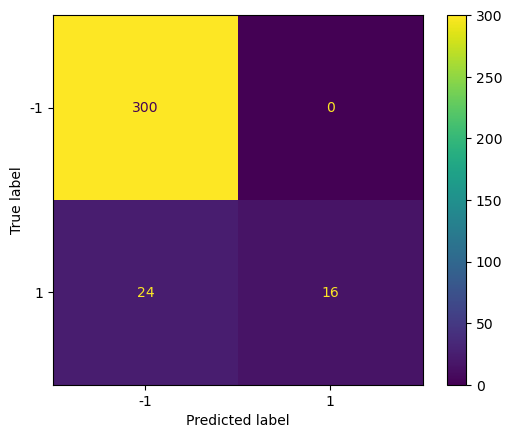

In [27]:
# a Pure TL
acc_oc_svm_AB, precision_oc_svm_AB, recall_oc_svm_AB, f1_oc_svm_AB = evaluate_model(one_class_svm_A, X_test_B, y_test_B)

Test Accuracy: 0.9941176470588236
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.99      1.00      1.00       300
         1.0       1.00      0.95      0.97        40

    accuracy                           0.99       340
   macro avg       1.00      0.97      0.99       340
weighted avg       0.99      0.99      0.99       340



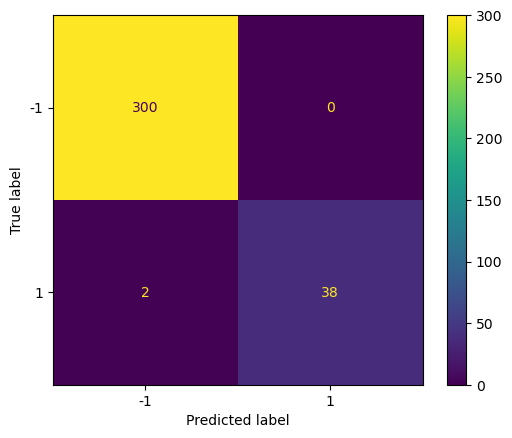

In [28]:
# b from scratch trained on domain b
one_class_svm_B = OneClassSVM(nu=one_class_svm_params_A['nu'], kernel = one_class_svm_params_A['kernel'], 
                             gamma = one_class_svm_params_A['gamma'])
one_class_svm_B.fit(X_train_B, y_train_B) 
acc_oc_svm_BB, precision_oc_svm_BB, recall_oc_svm_BB, f1_oc_svm_BB = evaluate_model(one_class_svm_B, X_test_B, y_test_B)

Test Accuracy: 0.9352941176470588
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.93      1.00      0.96       300
         1.0       1.00      0.45      0.62        40

    accuracy                           0.94       340
   macro avg       0.97      0.72      0.79       340
weighted avg       0.94      0.94      0.92       340



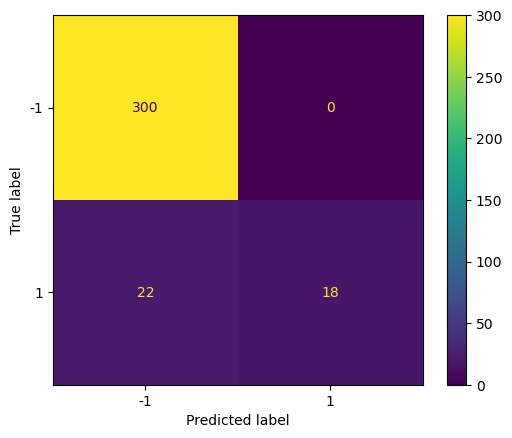

Test Accuracy: 0.9676470588235294
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.96      1.00      0.98       300
         1.0       1.00      0.72      0.84        40

    accuracy                           0.97       340
   macro avg       0.98      0.86      0.91       340
weighted avg       0.97      0.97      0.97       340



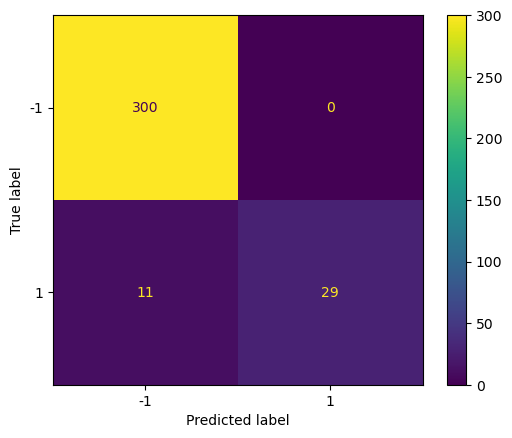

Test Accuracy: 0.9323529411764706
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.93      1.00      0.96       300
         1.0       1.00      0.42      0.60        40

    accuracy                           0.93       340
   macro avg       0.96      0.71      0.78       340
weighted avg       0.94      0.93      0.92       340



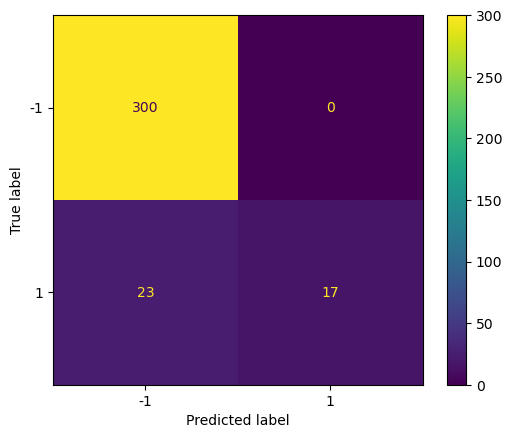

Test Accuracy: 0.9823529411764705
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.98      1.00      0.99       300
         1.0       1.00      0.85      0.92        40

    accuracy                           0.98       340
   macro avg       0.99      0.93      0.95       340
weighted avg       0.98      0.98      0.98       340



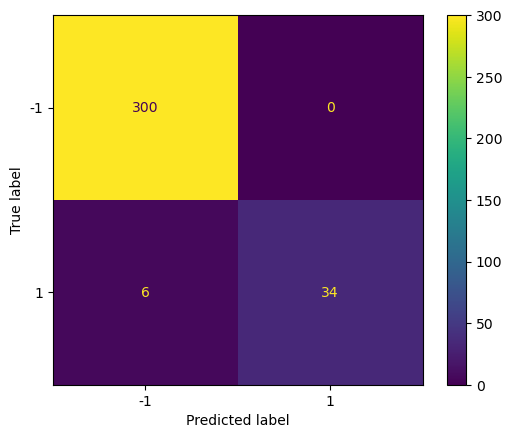

Test Accuracy: 0.9941176470588236
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.99      1.00      1.00       300
         1.0       1.00      0.95      0.97        40

    accuracy                           0.99       340
   macro avg       1.00      0.97      0.99       340
weighted avg       0.99      0.99      0.99       340



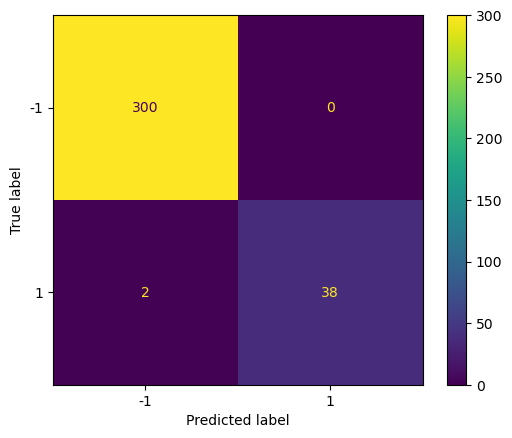

Test Accuracy: 0.9352941176470588
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.93      1.00      0.96       300
         1.0       1.00      0.45      0.62        40

    accuracy                           0.94       340
   macro avg       0.97      0.72      0.79       340
weighted avg       0.94      0.94      0.92       340



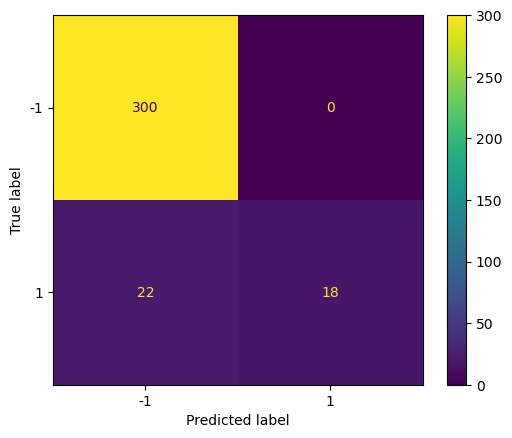

Test Accuracy: 0.9323529411764706
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.93      1.00      0.96       300
         1.0       1.00      0.42      0.60        40

    accuracy                           0.93       340
   macro avg       0.96      0.71      0.78       340
weighted avg       0.94      0.93      0.92       340



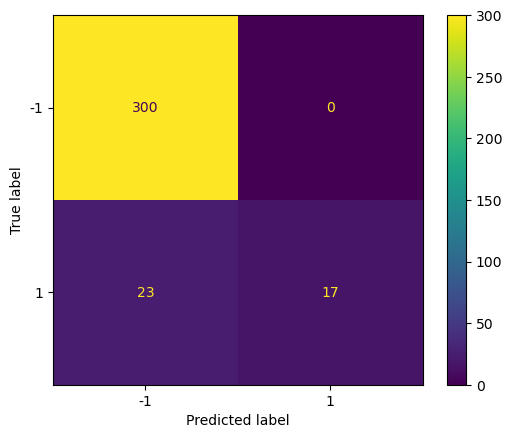

Test Accuracy: 0.9323529411764706
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.93      1.00      0.96       300
         1.0       1.00      0.42      0.60        40

    accuracy                           0.93       340
   macro avg       0.96      0.71      0.78       340
weighted avg       0.94      0.93      0.92       340



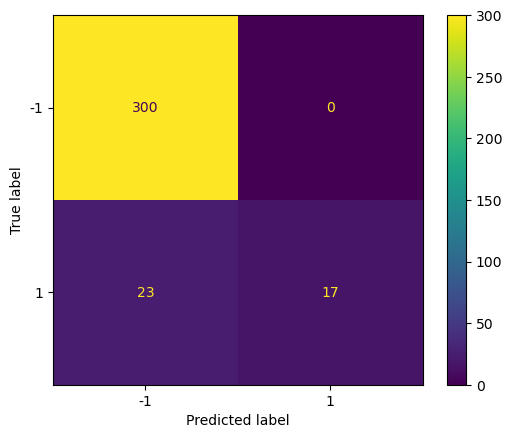

Test Accuracy: 0.9323529411764706
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.93      1.00      0.96       300
         1.0       1.00      0.42      0.60        40

    accuracy                           0.93       340
   macro avg       0.96      0.71      0.78       340
weighted avg       0.94      0.93      0.92       340



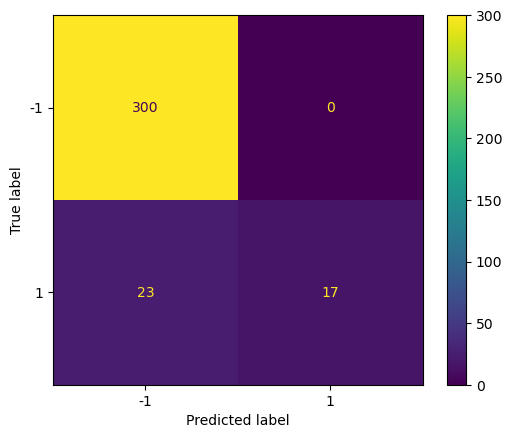

Test Accuracy: 0.9794117647058823
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.98      1.00      0.99       300
         1.0       1.00      0.82      0.90        40

    accuracy                           0.98       340
   macro avg       0.99      0.91      0.95       340
weighted avg       0.98      0.98      0.98       340



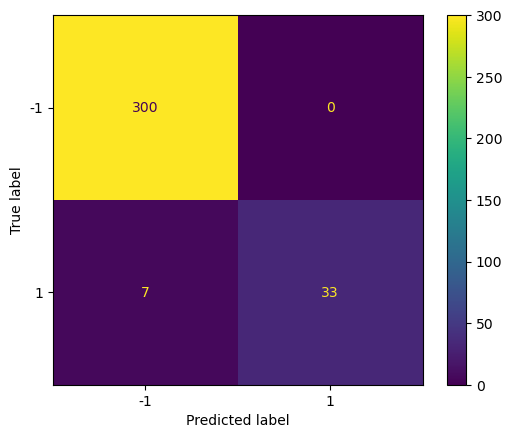

Test Accuracy: 0.9323529411764706
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.93      1.00      0.96       300
         1.0       1.00      0.42      0.60        40

    accuracy                           0.93       340
   macro avg       0.96      0.71      0.78       340
weighted avg       0.94      0.93      0.92       340



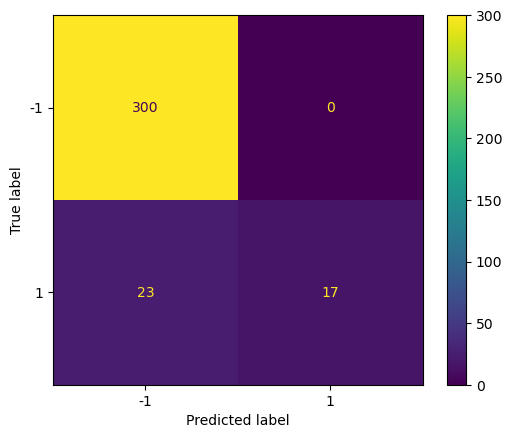

Test Accuracy: 0.9352941176470588
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.93      1.00      0.96       300
         1.0       1.00      0.45      0.62        40

    accuracy                           0.94       340
   macro avg       0.97      0.72      0.79       340
weighted avg       0.94      0.94      0.92       340



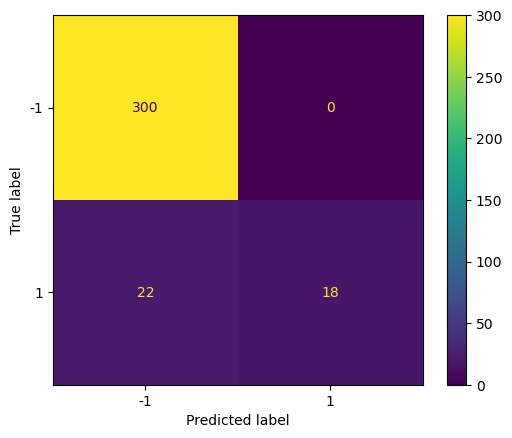

Test Accuracy: 0.9323529411764706
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.93      1.00      0.96       300
         1.0       1.00      0.42      0.60        40

    accuracy                           0.93       340
   macro avg       0.96      0.71      0.78       340
weighted avg       0.94      0.93      0.92       340



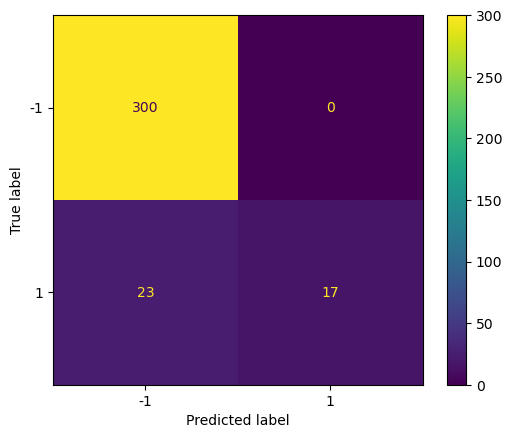

Test Accuracy: 0.9705882352941176
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.97      1.00      0.98       300
         1.0       1.00      0.75      0.86        40

    accuracy                           0.97       340
   macro avg       0.98      0.88      0.92       340
weighted avg       0.97      0.97      0.97       340



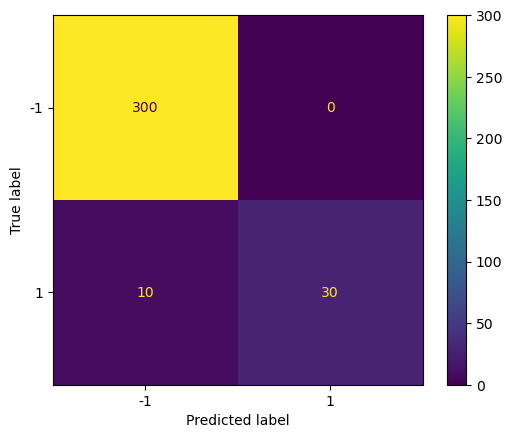

Test Accuracy: 0.9323529411764706
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.93      1.00      0.96       300
         1.0       1.00      0.42      0.60        40

    accuracy                           0.93       340
   macro avg       0.96      0.71      0.78       340
weighted avg       0.94      0.93      0.92       340



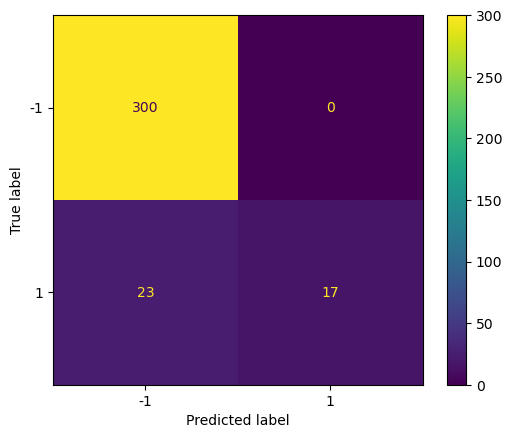

Test Accuracy: 0.9323529411764706
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.93      1.00      0.96       300
         1.0       1.00      0.42      0.60        40

    accuracy                           0.93       340
   macro avg       0.96      0.71      0.78       340
weighted avg       0.94      0.93      0.92       340



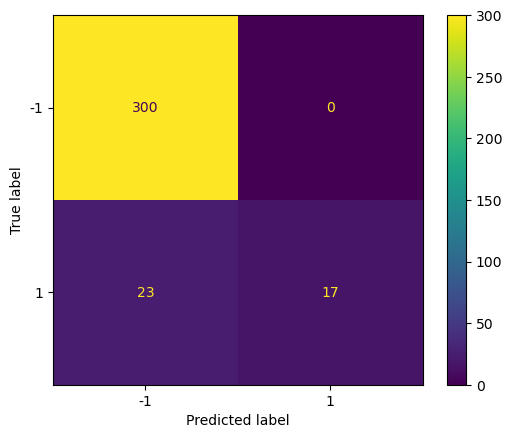

In [29]:
# c Domain adaptation
oc_svm_metric_lists=[]
for batch, batch_labels in zip(np.split(X_train_B, 16), np.split(y_train_B, 16)):
    one_class_svm_A.fit(batch, batch_labels)
    metric_list = evaluate_model(one_class_svm_A, X_test_B, y_test_B , return_list = True)
    oc_svm_metric_lists.append(metric_list)

In [30]:
#isol forest

Test Accuracy: 0.9058823529411765
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.90      1.00      0.95       300
         1.0       1.00      0.20      0.33        40

    accuracy                           0.91       340
   macro avg       0.95      0.60      0.64       340
weighted avg       0.91      0.91      0.88       340



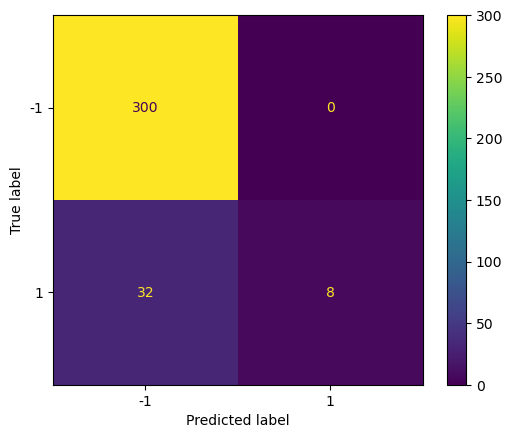

In [31]:
# a Pure TL
acc_isol_forest_AB, precision_isol_forest_AB, recall_isol_forest_AB, f1_isol_forest_AB = evaluate_model(isol_forest_A, X_test_B, y_test_B)

Test Accuracy: 0.9941176470588236
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.99      1.00      1.00       300
         1.0       1.00      0.95      0.97        40

    accuracy                           0.99       340
   macro avg       1.00      0.97      0.99       340
weighted avg       0.99      0.99      0.99       340



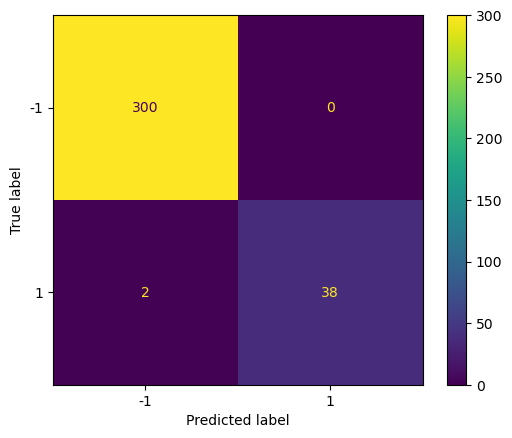

In [32]:
# b from scratch trained on domain b
isol_forest_B = IsolationForest(n_estimators=isol_forest_params_A['n_estimators'], max_samples=isol_forest_params_A['max_samples'], 
                                contamination=isol_forest_params_A['contamination'])
isol_forest_B.fit(X_train_B) 
acc_isol_forest_BB, precision_isol_forest_BB, recall_isol_forest_BB, f1_isol_forest_BB = evaluate_model(isol_forest_B, X_test_B, y_test_B)

10


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_iforest.py:307: UserWarning: max_samples (100) is greater than the total number of samples (10). max_samples will be set to n_samples for estimation.
  warn(


Test Accuracy: 0.9941176470588236
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.99      1.00      1.00       300
         1.0       1.00      0.95      0.97        40

    accuracy                           0.99       340
   macro avg       1.00      0.97      0.99       340
weighted avg       0.99      0.99      0.99       340



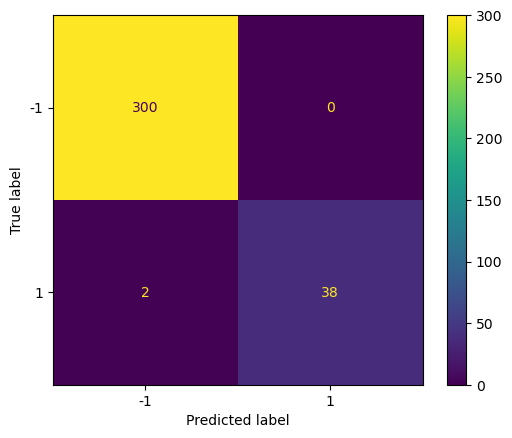

10


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_iforest.py:307: UserWarning: max_samples (100) is greater than the total number of samples (10). max_samples will be set to n_samples for estimation.
  warn(


Test Accuracy: 0.9970588235294118
Test classification report:
              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00       300
         1.0       1.00      0.97      0.99        40

    accuracy                           1.00       340
   macro avg       1.00      0.99      0.99       340
weighted avg       1.00      1.00      1.00       340



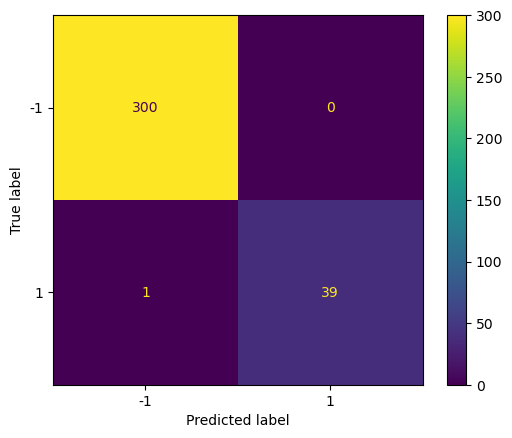

10


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_iforest.py:307: UserWarning: max_samples (100) is greater than the total number of samples (10). max_samples will be set to n_samples for estimation.
  warn(


Test Accuracy: 0.9882352941176471
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.99      1.00      0.99       300
         1.0       1.00      0.90      0.95        40

    accuracy                           0.99       340
   macro avg       0.99      0.95      0.97       340
weighted avg       0.99      0.99      0.99       340



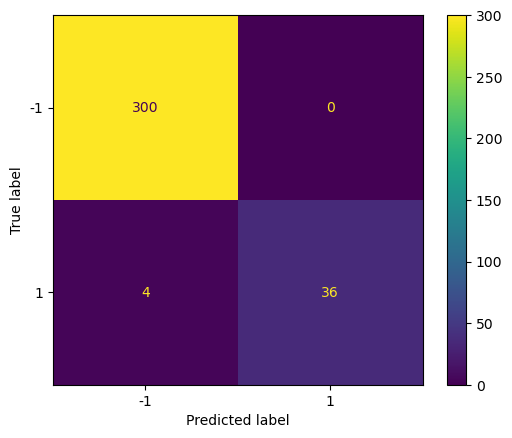

10


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_iforest.py:307: UserWarning: max_samples (100) is greater than the total number of samples (10). max_samples will be set to n_samples for estimation.
  warn(


Test Accuracy: 0.9970588235294118
Test classification report:
              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00       300
         1.0       1.00      0.97      0.99        40

    accuracy                           1.00       340
   macro avg       1.00      0.99      0.99       340
weighted avg       1.00      1.00      1.00       340



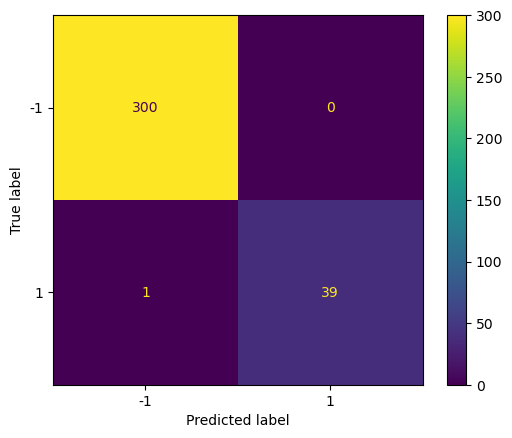

10


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_iforest.py:307: UserWarning: max_samples (100) is greater than the total number of samples (10). max_samples will be set to n_samples for estimation.
  warn(


Test Accuracy: 0.9970588235294118
Test classification report:
              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00       300
         1.0       1.00      0.97      0.99        40

    accuracy                           1.00       340
   macro avg       1.00      0.99      0.99       340
weighted avg       1.00      1.00      1.00       340



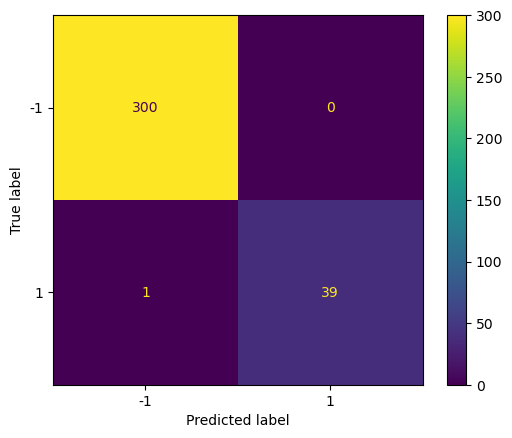

10


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_iforest.py:307: UserWarning: max_samples (100) is greater than the total number of samples (10). max_samples will be set to n_samples for estimation.
  warn(


Test Accuracy: 0.9794117647058823
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.98      1.00      0.99       300
         1.0       1.00      0.82      0.90        40

    accuracy                           0.98       340
   macro avg       0.99      0.91      0.95       340
weighted avg       0.98      0.98      0.98       340



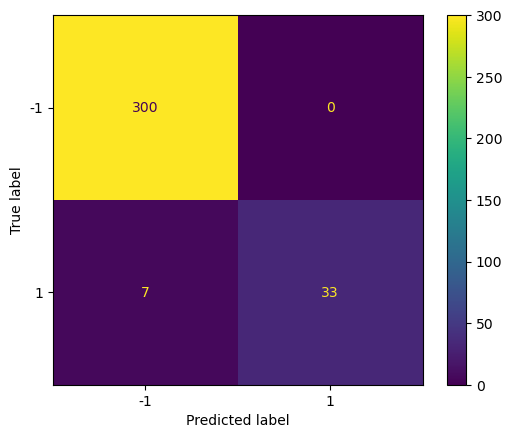

10


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_iforest.py:307: UserWarning: max_samples (100) is greater than the total number of samples (10). max_samples will be set to n_samples for estimation.
  warn(


Test Accuracy: 0.9941176470588236
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.99      1.00      1.00       300
         1.0       1.00      0.95      0.97        40

    accuracy                           0.99       340
   macro avg       1.00      0.97      0.99       340
weighted avg       0.99      0.99      0.99       340



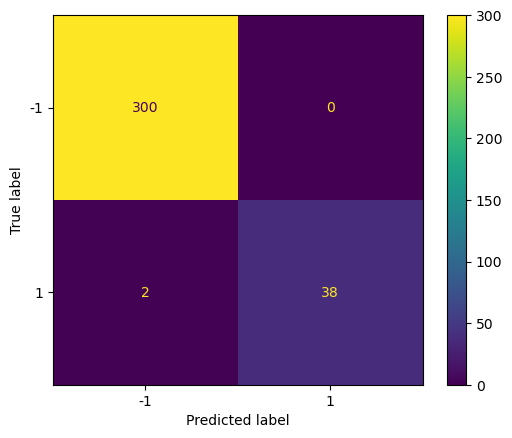

10


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_iforest.py:307: UserWarning: max_samples (100) is greater than the total number of samples (10). max_samples will be set to n_samples for estimation.
  warn(


Test Accuracy: 0.9823529411764705
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.98      1.00      0.99       300
         1.0       1.00      0.85      0.92        40

    accuracy                           0.98       340
   macro avg       0.99      0.93      0.95       340
weighted avg       0.98      0.98      0.98       340



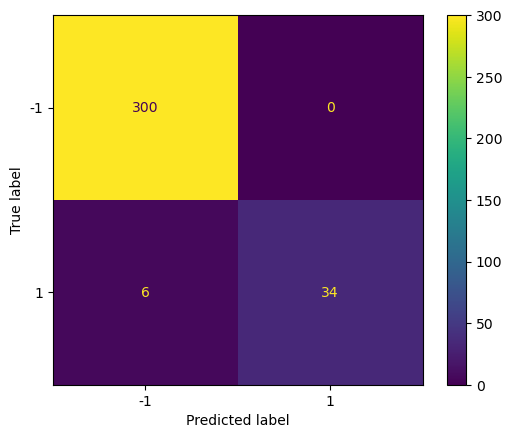

10


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_iforest.py:307: UserWarning: max_samples (100) is greater than the total number of samples (10). max_samples will be set to n_samples for estimation.
  warn(


Test Accuracy: 0.9529411764705882
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.95      1.00      0.97       300
         1.0       1.00      0.60      0.75        40

    accuracy                           0.95       340
   macro avg       0.97      0.80      0.86       340
weighted avg       0.96      0.95      0.95       340



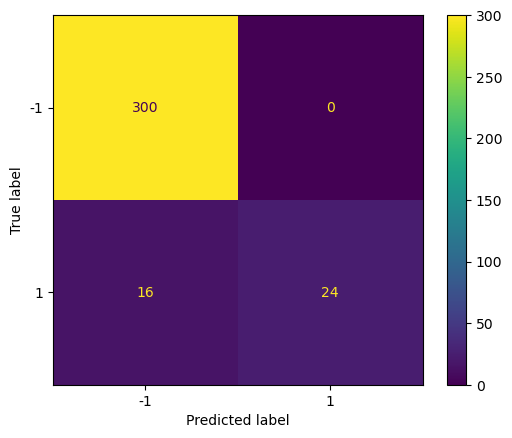

10


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_iforest.py:307: UserWarning: max_samples (100) is greater than the total number of samples (10). max_samples will be set to n_samples for estimation.
  warn(


Test Accuracy: 0.9911764705882353
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.99      1.00      1.00       300
         1.0       1.00      0.93      0.96        40

    accuracy                           0.99       340
   macro avg       1.00      0.96      0.98       340
weighted avg       0.99      0.99      0.99       340



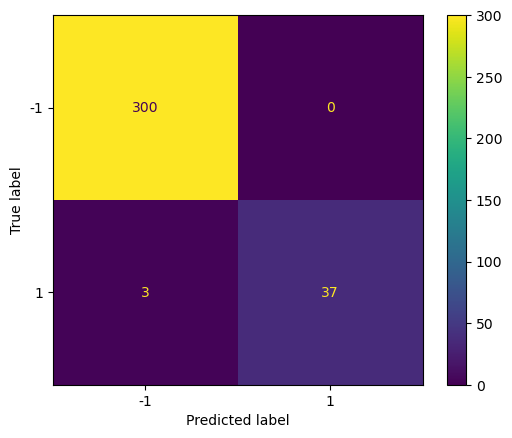

10


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_iforest.py:307: UserWarning: max_samples (100) is greater than the total number of samples (10). max_samples will be set to n_samples for estimation.
  warn(


Test Accuracy: 0.9882352941176471
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.99      1.00      0.99       300
         1.0       1.00      0.90      0.95        40

    accuracy                           0.99       340
   macro avg       0.99      0.95      0.97       340
weighted avg       0.99      0.99      0.99       340



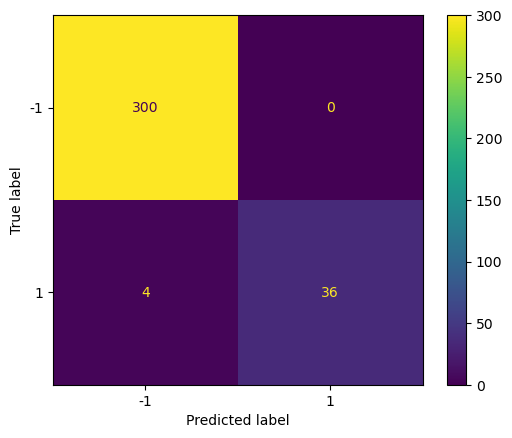

10


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_iforest.py:307: UserWarning: max_samples (100) is greater than the total number of samples (10). max_samples will be set to n_samples for estimation.
  warn(


Test Accuracy: 0.9941176470588236
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.99      1.00      1.00       300
         1.0       1.00      0.95      0.97        40

    accuracy                           0.99       340
   macro avg       1.00      0.97      0.99       340
weighted avg       0.99      0.99      0.99       340



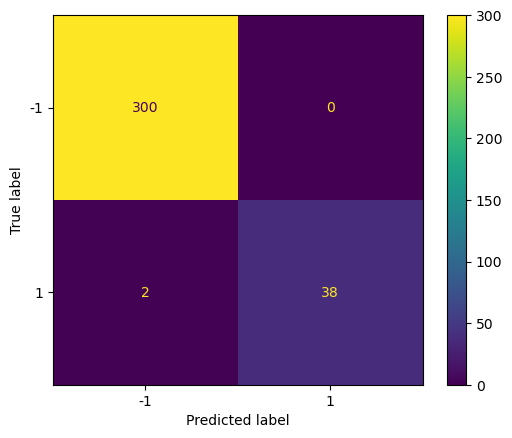

10


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_iforest.py:307: UserWarning: max_samples (100) is greater than the total number of samples (10). max_samples will be set to n_samples for estimation.
  warn(


Test Accuracy: 0.9735294117647059
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.97      1.00      0.99       300
         1.0       1.00      0.78      0.87        40

    accuracy                           0.97       340
   macro avg       0.99      0.89      0.93       340
weighted avg       0.97      0.97      0.97       340



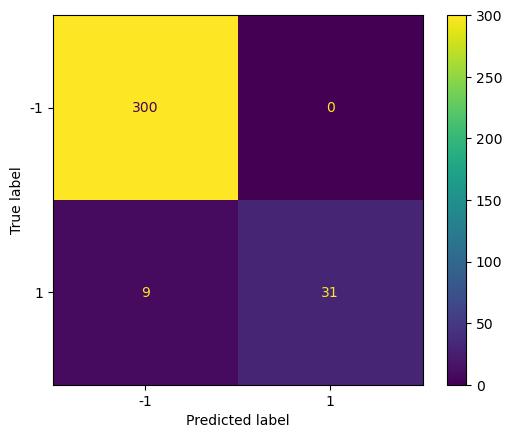

10


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_iforest.py:307: UserWarning: max_samples (100) is greater than the total number of samples (10). max_samples will be set to n_samples for estimation.
  warn(


Test Accuracy: 0.9941176470588236
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.99      1.00      1.00       300
         1.0       1.00      0.95      0.97        40

    accuracy                           0.99       340
   macro avg       1.00      0.97      0.99       340
weighted avg       0.99      0.99      0.99       340



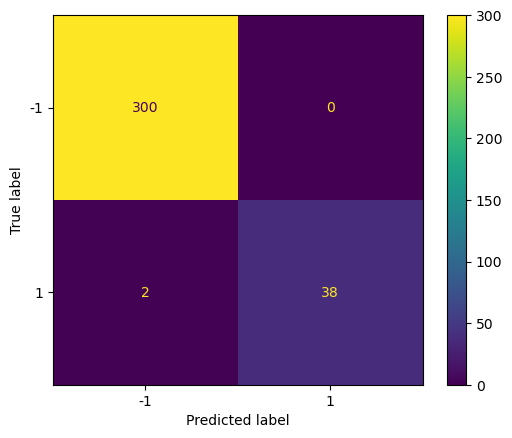

10


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_iforest.py:307: UserWarning: max_samples (100) is greater than the total number of samples (10). max_samples will be set to n_samples for estimation.
  warn(


Test Accuracy: 0.9558823529411765
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.95      1.00      0.98       300
         1.0       1.00      0.62      0.77        40

    accuracy                           0.96       340
   macro avg       0.98      0.81      0.87       340
weighted avg       0.96      0.96      0.95       340



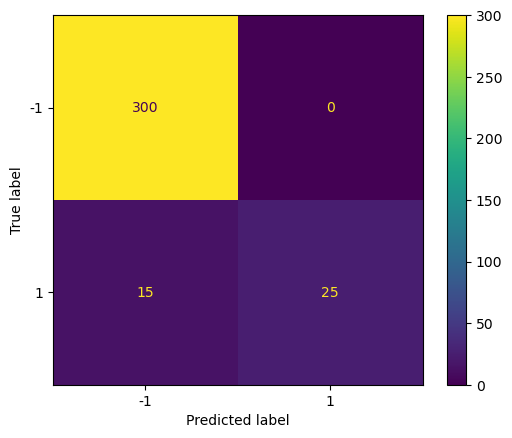

10


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_iforest.py:307: UserWarning: max_samples (100) is greater than the total number of samples (10). max_samples will be set to n_samples for estimation.
  warn(


Test Accuracy: 0.9882352941176471
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.99      1.00      0.99       300
         1.0       1.00      0.90      0.95        40

    accuracy                           0.99       340
   macro avg       0.99      0.95      0.97       340
weighted avg       0.99      0.99      0.99       340



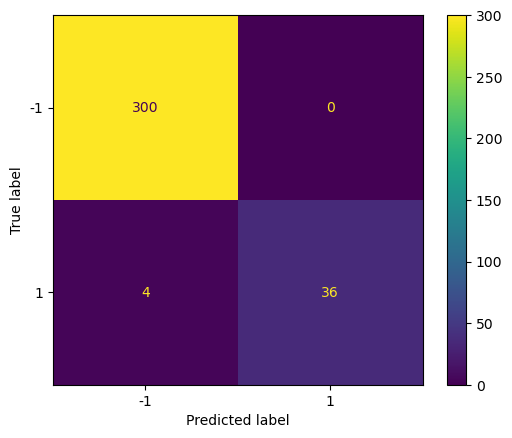

In [33]:
# c Domain adaptation
isol_forest_metric_lists=[]
for batch, batch_labels in zip(np.split(X_train_B, 16), np.split(y_train_B, 16)):
    print(batch.shape[0])
    isol_forest_A.fit(batch)
    metric_list = evaluate_model(isol_forest_A, X_test_B, y_test_B, return_list=True)
    isol_forest_metric_lists.append(metric_list)

# 5) PLOTS

In [34]:
# Lists of classification metrics - original & resized & cropped images
accuracies_oc_svm = [acc_oc_svm_A, acc_one_class_svm_pca, acc_one_class_svm_resize, acc_one_class_svm_resize_pca] 
precisions_oc_svm = [precision_oc_svm_A, precision_one_class_svm_pca, precision_one_class_svm_resize, precision_one_class_svm_resize_pca]
recalls_oc_svm = [recall_oc_svm_A, recall_one_class_svm_pca, recall_one_class_svm_resize, recall_one_class_svm_resize_pca]
f1s_oc_svm = [f1_oc_svm_A, f1_one_class_svm_pca, f1_one_class_svm_resize, f1_one_class_svm_resize_pca]

accuracies_isol_forest = [acc_isol_forest_A, acc_isol_forest_pca, acc_isol_forest_resize, acc_isol_forest_resize_pca]
precisions_isol_forest = [precision_isol_forest_A, precision_isol_forest_pca, precision_isol_forest_resize, precision_isol_forest_resize_pca]
recalls_isol_forest = [recall_isol_forest_A, recall_isol_forest_pca, recall_isol_forest_resize, recall_isol_forest_resize_pca]
f1s_isol_forest = [f1_isol_forest_A, f1_isol_forest_pca, f1_isol_forest_resize, f1_isol_forest_resize_pca]

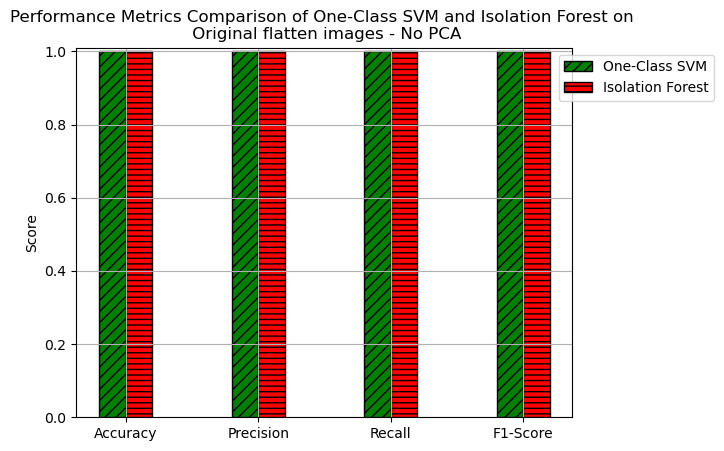

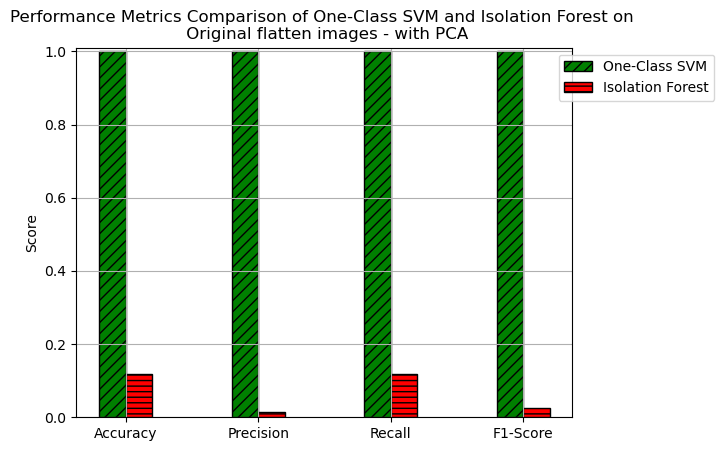

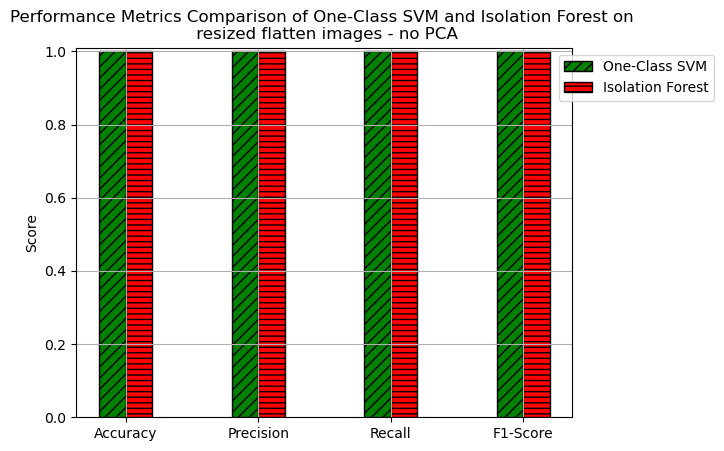

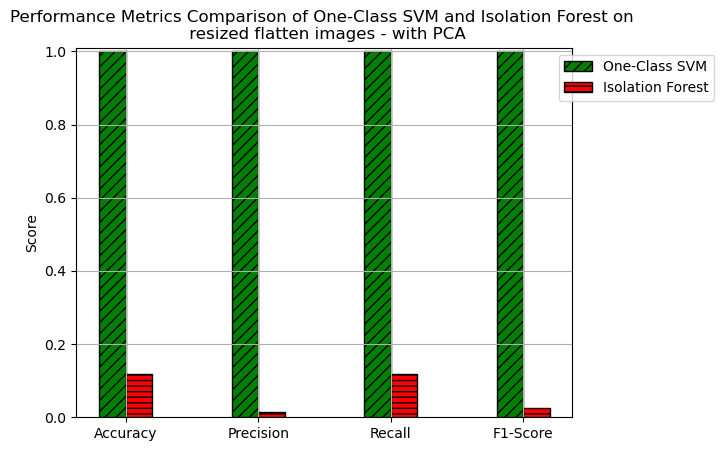

In [35]:

title_list = ["Original flatten images - No PCA" , "Original flatten images - with PCA", "resized flatten images - no PCA",
               "resized flatten images - with PCA" ]
#---------------plots---------------#
x_svm = np.arange(4)-0.1  # the x locations for the bars in global metrics plot
x_if = np.arange(4)+0.1  # the x locations for the bars in global metrics plot
#x2_svm = np.arange(6)-0.1  # the x locations for the bars in precision/recall/f1-score metrics plot
#x2K = np.arange(6)+0.1  # the x locations for the bars in precision/recall/f1-score metrics plot
w = 0.2       # the width of the bars

# 1) global metrics
for i in range(len(title_list)):
    plt.bar(x_svm, [accuracies_oc_svm[i], precisions_oc_svm[i], recalls_oc_svm[i], f1s_oc_svm[i]],
            width=w, edgecolor='black', color='g', align='center', hatch='///', label='One-Class SVM')
    plt.bar(x_if, [accuracies_isol_forest[i], precisions_isol_forest[i], recalls_isol_forest[i], f1s_isol_forest[i]],
            width=w, edgecolor='black', color='r', align='center', hatch='---', label='Isolation Forest')
    plt.xticks(x_svm + 0.1, ["Accuracy", "Precision", "Recall", "F1-Score"])
    plt.title('Performance Metrics Comparison of One-Class SVM and Isolation Forest on \n {}'.format(title_list[i]))
    plt.ylabel('Score')
    plt.ylim([0, 1.01])
    plt.grid()
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
    plt.show()




In [36]:
# TL -plots

In [37]:
def plot_tl(metric_lists, pure_tl, allb_tl, batch_size = batch.shape[0]):
    accuracy_da = [sublist[0] for sublist in metric_lists]
    precision_da = [sublist[1] for sublist in metric_lists]
    recall_da = [sublist[2] for sublist in metric_lists]
    f1_da = [sublist[3] for sublist in metric_lists]


    num_batches = len(accuracy_da)
    x_values = batch_size + np.arange(0, num_batches) * batch_size

# Plot accuracy_da
    plt.figure()
    plt.plot(x_values, accuracy_da, marker="o")
    plt.axhline(pure_tl[0], color='r', linestyle='--', label='Pure Transfer Learning')
    plt.axhline(allb_tl[0], color='g', linestyle='--', label='Training only on domain B')
    plt.xlabel('Number of Samples from Domain B')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Number of Samples from Domain B')
    plt.legend(loc='upper right', bbox_to_anchor=(1.55, 1.1))



# Plot precision_da
    plt.figure()
    plt.plot(x_values, precision_da, marker="o")
    plt.axhline(pure_tl[1], color='r', linestyle='--', label='Pure Transfer Learning')
    plt.axhline(allb_tl[1], color='g', linestyle='--', label='Training only on domain B')
    plt.xlabel('Number of Samples from Domain B')
    plt.ylabel('Precision')
    plt.title('Precision vs Number of Samples from Domain B')
    plt.legend(loc='upper right', bbox_to_anchor=(1.55, 1.1))

# Plot recall_da
    plt.figure()
    plt.plot(x_values, recall_da, marker="o")
    plt.axhline(allb_tl[2], color='g', linestyle='--', label='Training only on domain B')
    plt.axhline(pure_tl[2], color='r', linestyle='--', label='Pure Transfer Learning')
    plt.xlabel('Number of Samples from Domain B')
    plt.ylabel('Recall')
    plt.title('Recall vs Number of Samples from Domain B')
    plt.legend(loc='upper right', bbox_to_anchor=(1.55, 1.1))

# Plot f1_da
    plt.figure()
    plt.plot(x_values, f1_da, marker="o")
    plt.axhline(pure_tl[3], color='r', linestyle='--', label='Pure Transfer Learning')
    plt.axhline(allb_tl[3], color='g', linestyle='--', label='Training only on domain B')
    plt.xlabel('Number of Samples from Domain B')
    plt.ylabel('F1-score')
    plt.title('F1-score vs Number of Samples from Domain B')
    plt.legend(loc='upper right', bbox_to_anchor=(1.55, 1.1))

    plt.show()

    

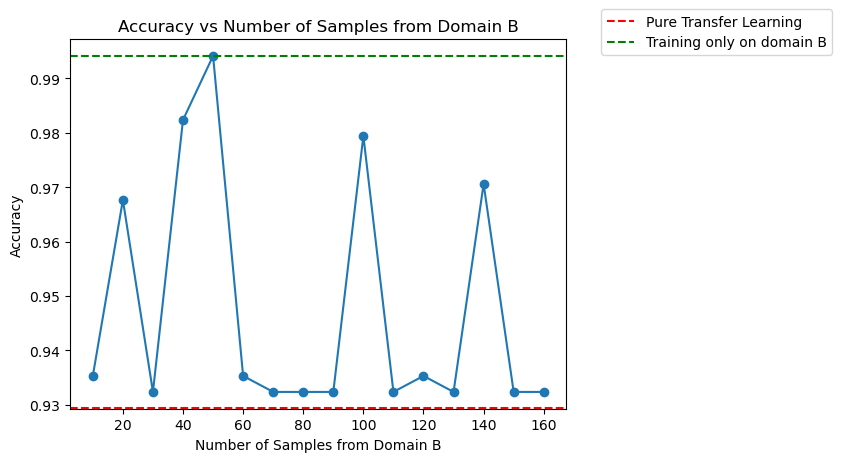

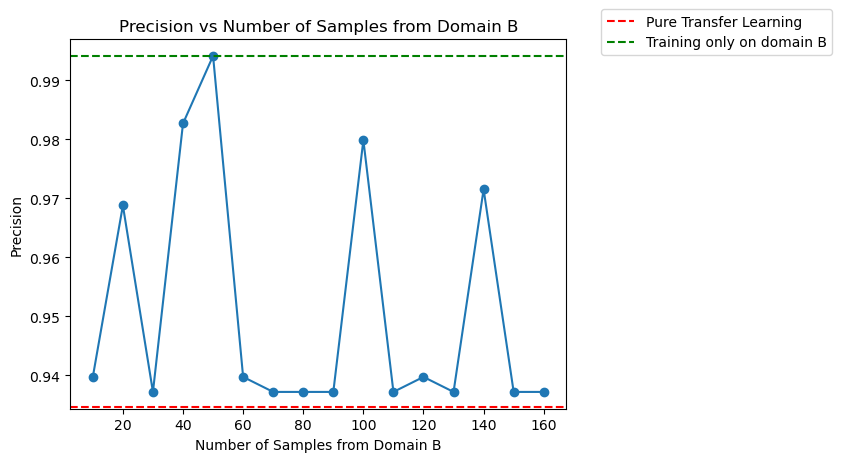

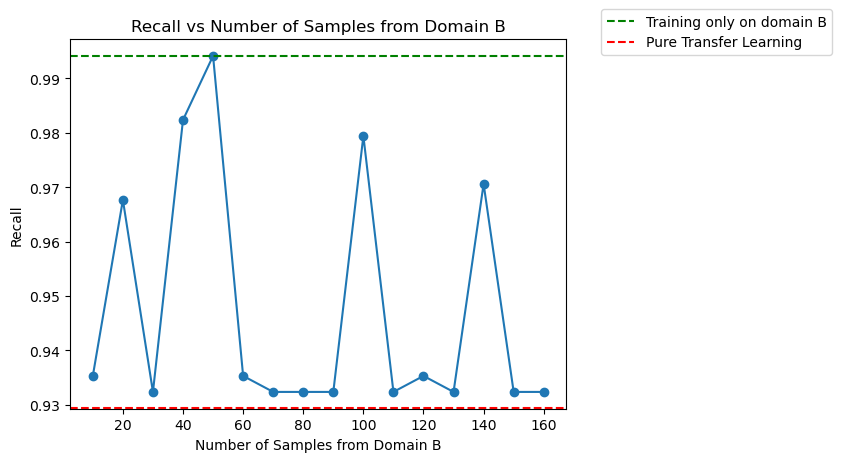

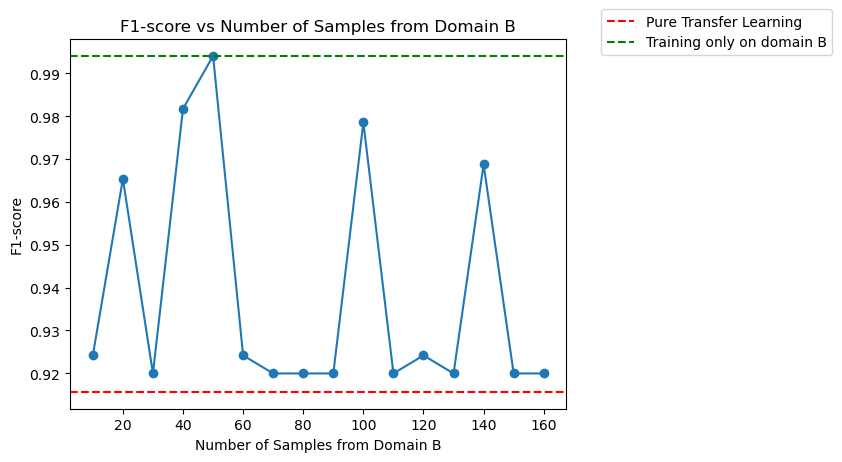

In [38]:
# TL plot - oc svm
oc_svm_pure_tl = [acc_oc_svm_AB, precision_oc_svm_AB, recall_oc_svm_AB, f1_oc_svm_AB]
oc_svm_allb_tl = [acc_oc_svm_BB, precision_oc_svm_BB, recall_oc_svm_BB, f1_oc_svm_BB]
plot_tl(oc_svm_metric_lists, oc_svm_pure_tl, oc_svm_allb_tl, batch_size = batch.shape[0])

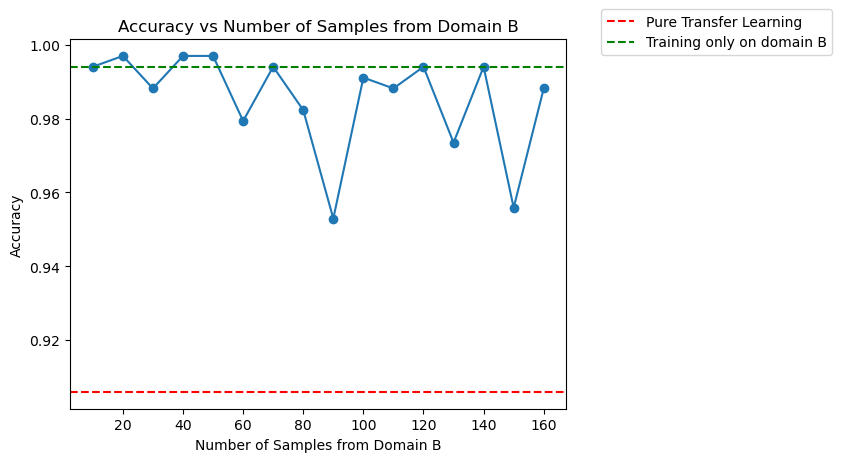

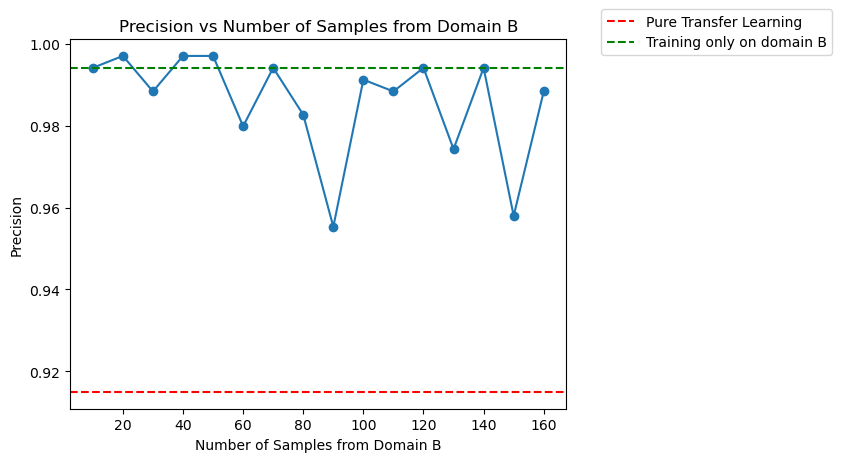

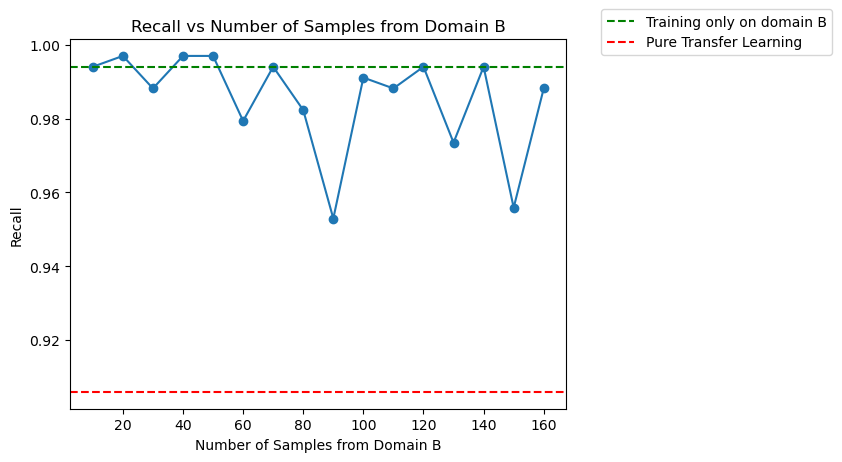

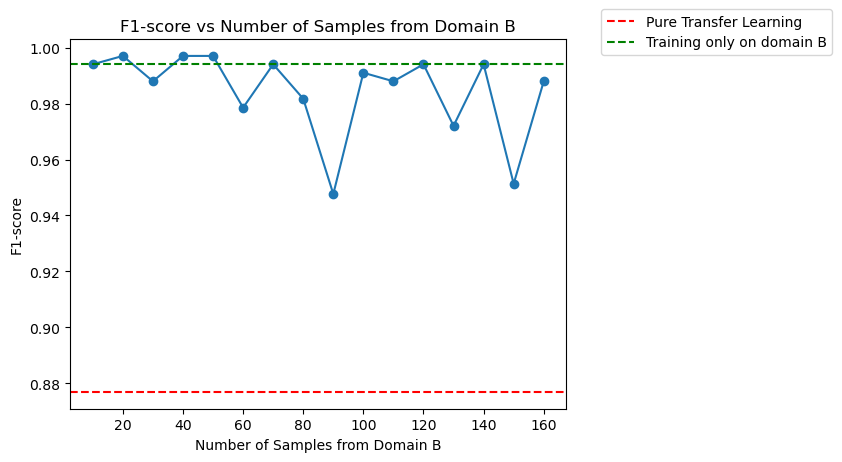

In [39]:
# TL plot - IF
isol_forest_pure_tl = [acc_isol_forest_AB, precision_isol_forest_AB, recall_isol_forest_AB, f1_isol_forest_AB]
isol_forest_allb_tl = [acc_isol_forest_BB, precision_isol_forest_BB, recall_isol_forest_BB, f1_isol_forest_BB]
plot_tl(isol_forest_metric_lists, isol_forest_pure_tl, isol_forest_allb_tl, batch_size = batch.shape[0])

# TL DOESN'T SEEM TO WORK PROPERLY -> EXPLAINABILITY (BUT WITH LABELS)

In [40]:
import os
import random
import numpy as np 
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import vgg16
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, ImageDataGenerator


seed = 42
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
random.seed(seed)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [41]:
def preprocess_images(images):
    expanded_images = np.expand_dims(images, axis=-1)
    resized_images = tf.image.resize(expanded_images, (224, 224))
    normalized_images = resized_images / 255.0
    return normalized_images


def get_model():
    model = models.Sequential()
    model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 1), name='conv_1'))
    model.add(layers.MaxPooling2D((2, 2), name='mp1'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', name='conv_2'))
    model.add(layers.MaxPooling2D((2, 2), name='mp2'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', name='conv_3'))
    model.add(layers.MaxPooling2D((2, 2), name='mp3'))
    #model.add(layers.Conv2D(256, (3, 3), activation='relu', name='conv_4'))
    #model.add(layers.MaxPooling2D((2, 2), name='mp4'))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu', name='dense1'))
    model.add(layers.Dense(1, activation='sigmoid', name = 'out'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [42]:
images_norm1, img_shape = load_visualize(path_norm1, 'Normal1')
images_norm2, _ = load_visualize(path_norm2, 'Normal2')

images_fault_50, _ = load_visualize(path_fault_50, 'Faulty1')
images_fault_43, _ = load_visualize(path_fault_43, 'Faulty2')
images_fault_37, _ = load_visualize(path_fault_37, 'Faulty3')


# preprocess for vgg16
images_norm1 = preprocess_images(images_norm1)
images_norm2 = preprocess_images(images_norm2)
images_fault_50 = preprocess_images(images_fault_50)
images_fault_43 = preprocess_images(images_fault_43)
images_fault_37 = preprocess_images(images_fault_37)


# labels
num_norm1 = len(images_norm1)
num_norm2 = len(images_norm2)
num_fault_50 = len(images_fault_50)
num_fault_43 = len(images_fault_43)
num_fault_37 = len(images_fault_37)

labels_norm1 = np.zeros(num_norm1)
labels_norm2 = np.zeros(num_norm2)
labels_fault_50 = np.ones(num_fault_50)
labels_fault_43 = np.ones(num_fault_43)
labels_fault_37 = np.ones(num_fault_37)


X = np.concatenate([images_norm1, images_norm2, images_fault_50, images_fault_43, images_fault_37], axis=0)
X = np.reshape(X, (-1, 224, 224, 1))
y = np.concatenate([labels_norm1, labels_norm2, labels_fault_50, labels_fault_43, labels_fault_37], axis=0)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape)

------------Normal1---------------
Number of imges:  100
Image size:  (614, 614)
------------Normal2---------------
Number of imges:  100
Image size:  (614, 614)
------------Faulty1---------------
Number of imges:  100
Image size:  (614, 614)
------------Faulty2---------------
Number of imges:  100
Image size:  (614, 614)
------------Faulty3---------------
Number of imges:  100
Image size:  (614, 614)
(400, 224, 224, 1) (100, 224, 224, 1)


In [43]:
model = get_model()

model.fit(X_train, y_train, epochs=3, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/3
13/13 [==============================] - 11s 117ms/step - loss: 0.4447 - accuracy: 0.8750 - val_loss: 2.7767e-04 - val_accuracy: 1.0000
Epoch 2/3
13/13 [==============================] - 1s 50ms/step - loss: 0.0710 - accuracy: 0.9875 - val_loss: 0.2700 - val_accuracy: 0.9500
Epoch 3/3
13/13 [==============================] - 1s 48ms/step - loss: 0.2467 - accuracy: 0.9575 - val_loss: 0.0592 - val_accuracy: 0.9900


In [44]:
def generate_grad_cam(model, image, class_index):
    # Expand dimensions to create a batch of size 1
    image = np.expand_dims(image, axis=0)
    # Get the target layer for gradient calculation
    target_layer = model.get_layer('mp3')
    # Create a new model to get the output and gradients
    grad_model = tf.keras.models.Model([model.inputs], [target_layer.output, model.output])

    # Calculate the gradient of the predicted class with respect to the target layer output
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(image)
        loss = predictions[:, class_index]
    grads = tape.gradient(loss, conv_output)

    # Compute the per-channel importance weights by averaging gradients spatially
    weights = tf.reduce_mean(grads, axis=(1, 2))

    # Multiply the channel-wise weights with the target layer output
    cam = tf.reduce_sum(tf.multiply(weights, conv_output), axis=-1)
    cam = np.maximum(cam, 0)  # ReLU activation
    cam /= np.max(cam)  # Normalize between 0 and 1

    # Resize the heatmap to match the input image size
    cam = cv2.resize(cam[0], (image.shape[2], image.shape[1]))

    return cam


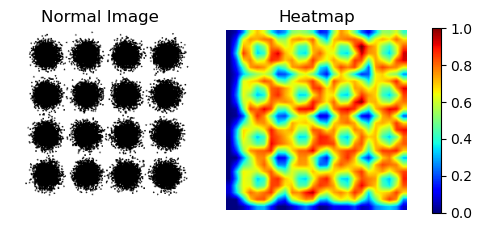

In [45]:
example_index = 300  # Try "1", "300"
example_image = X_train[example_index]
preprocessed_image = example_image.astype('float32') / 255.0

class_index = 0  # Index of the class for which you want to visualize the heatmap
heatmap = generate_grad_cam(model, preprocessed_image, class_index)

# Plot the original image, heatmap, and the superimposed image
fig, axs = plt.subplots(1, 2)
axs[0].imshow(example_image, cmap='gray')
axs[0].axis('off')
axs[0].set_title('Normal Image')
axs[1].imshow(heatmap, cmap='jet')
axs[1].axis('off')
axs[1].set_title('Heatmap')

plt.colorbar(plt.cm.ScalarMappable(cmap='jet'), ax=axs, shrink = 0.5)

plt.show()

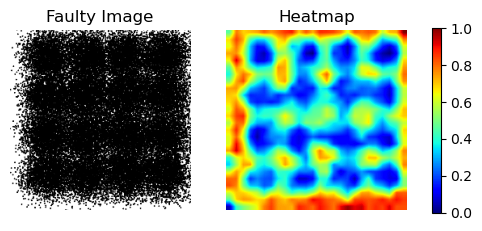

In [46]:
example_index = 1  
example_image = X_train[example_index]
preprocessed_image = example_image.astype('float32') / 255.0

class_index = 0  # Index of the class for which you want to visualize the heatmap
heatmap = generate_grad_cam(model, preprocessed_image, class_index)

# Plot the original image, heatmap, and the superimposed image
fig, axs = plt.subplots(1, 2)
axs[0].imshow(example_image, cmap='gray')
axs[0].axis('off')
axs[0].set_title('Faulty Image')
axs[1].imshow(heatmap, cmap='jet')
axs[1].axis('off')
axs[1].set_title('Heatmap')

plt.colorbar(plt.cm.ScalarMappable(cmap='jet'), ax=axs, shrink = 0.5)

plt.show()

====================================================
# One symbol only
====================================================

# 1a) One-symbol images

In [47]:
import random
random.seed(42)

# extract 1 symbol. but use only 100 samples per class


images_norm1_1, img_shape = load_visualize(path_norm1, 'Normal1', one_symbol = True)
ind = random.sample(range(images_norm1_1.shape[0]),100)
images_norm1_1 = images_norm1_1[ind, :, :]
images_norm2_1, _ = load_visualize(path_norm2, 'Normal2', one_symbol = True)
images_norm2_1 = images_norm2_1[ind, :, :]

images_fault_50_1, _ = load_visualize(path_fault_50, 'Faulty1', one_symbol = True)
images_fault_50_1 = images_fault_50_1[ind, :, :]
images_fault_43_1, _ = load_visualize(path_fault_43, 'Faulty2', one_symbol = True)
images_fault_43_1 = images_fault_43_1[ind, :, :]
images_fault_37_1, _ = load_visualize(path_fault_37, 'Faulty3', one_symbol = True)
images_fault_37_1 = images_fault_37_1[ind, :, :]
#images_fault_37_1.shape

------------Normal1---------------
Number of imges:  1600
Image size:  (142, 142)
------------Normal2---------------
Number of imges:  1600
Image size:  (142, 142)
------------Faulty1---------------
Number of imges:  1600
Image size:  (142, 142)
------------Faulty2---------------
Number of imges:  1600
Image size:  (142, 142)
------------Faulty3---------------
Number of imges:  1600
Image size:  (142, 142)


In [48]:
# flatten each image
norm1_flat_1 = flatten_normalize(images_norm1_1, img_shape)
norm2_flat_1 = flatten_normalize(images_norm2_1, img_shape)

fault1_flat_1 = flatten_normalize(images_fault_50_1, img_shape)
fault2_flat_1 = flatten_normalize(images_fault_43_1, img_shape)
fault3_flat_1 = flatten_normalize(images_fault_37_1, img_shape)

(100, 20164)
(100, 20164)
(100, 20164)
(100, 20164)
(100, 20164)


In [49]:
X_train, X_val, X_test, y_train, y_val, y_test  = Train_test_val_split(norm1_flat_1, norm2_flat_1, fault1_flat_1, fault2_flat_1, fault3_flat_1)

The number of records in the training dataset is 160 #-1: 0  #1: 160
The number of records in the validation dataset is 272 #-1: 240  #1: 32
The number of records in the testing dataset is 68 #-1: 60  #1: 8


Testing hyperparameters: nu: 0.01, kernel: rbf, gamma: scale
score 0.9027800053461641
Testing hyperparameters: nu: 0.01, kernel: rbf, gamma: auto
score 0.9352044907778669
Testing hyperparameters: nu: 0.01, kernel: sigmoid, gamma: scale
score 0.9721197540764501
Testing hyperparameters: nu: 0.01, kernel: sigmoid, gamma: auto
score 0.9838011226944667
Testing hyperparameters: nu: 0.01, kernel: linear, gamma: scale
score 0.9838011226944667
Testing hyperparameters: nu: 0.01, kernel: linear, gamma: auto
score 0.9838011226944667
Testing hyperparameters: nu: 0.2, kernel: rbf, gamma: scale
score 0.8726276396685376
Testing hyperparameters: nu: 0.2, kernel: rbf, gamma: auto
score 0.8842288158246457
Testing hyperparameters: nu: 0.2, kernel: sigmoid, gamma: scale
score 0.9050788559208767
Testing hyperparameters: nu: 0.2, kernel: sigmoid, gamma: auto
score 0.9120556001069232
Testing hyperparameters: nu: 0.2, kernel: linear, gamma: scale
score 0.9120556001069232
Testing hyperparameters: nu: 0.2, kerne

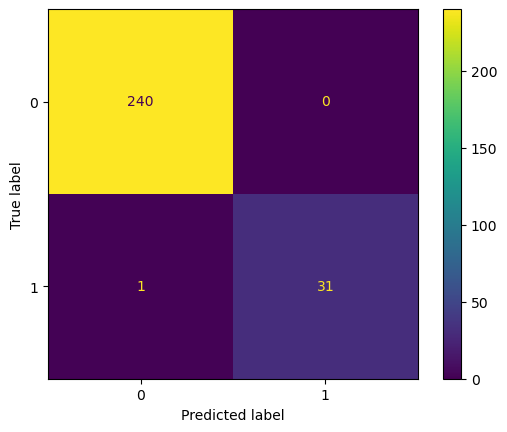

Average K-fold accuracy: 0.9838011226944667 +- 0.011837679860569255
Test Accuracy: 1.0
Test classification report:
              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00        60
         1.0       1.00      1.00      1.00         8

    accuracy                           1.00        68
   macro avg       1.00      1.00      1.00        68
weighted avg       1.00      1.00      1.00        68



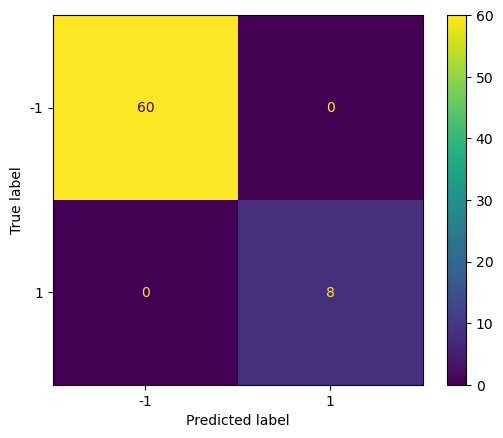

In [50]:
# OC_SVM
# val
one_class_svm_A_1, one_class_svm_params_A_1, stat = CV_one_class_svm(X_train, y_train, X_val, y_val, 5)
print('Average K-fold accuracy:', np.mean(stat),'+-', np.std(stat))

acc_oc_svm_A_1, precision_oc_svm_A_1, recall_oc_svm_A_1, f1_oc_svm_A_1 = evaluate_model(one_class_svm_A_1, X_test, y_test)

Testing hyperparameters: n_estimators: 50, max_samples: 10, contamination: 0.1
score 0.9420743116813686
Testing hyperparameters: n_estimators: 50, max_samples: 10, contamination: 0.3
score 0.870462443197006
Testing hyperparameters: n_estimators: 50, max_samples: 50, contamination: 0.1
score 0.9629510825982358
Testing hyperparameters: n_estimators: 50, max_samples: 50, contamination: 0.3
score 0.8703822507350975
Testing hyperparameters: n_estimators: 50, max_samples: 100, contamination: 0.1
score 0.9537824111200214
Testing hyperparameters: n_estimators: 50, max_samples: 100, contamination: 0.3
score 0.8610531943330659
Testing hyperparameters: n_estimators: 75, max_samples: 10, contamination: 0.1
score 0.9561079925153703
Testing hyperparameters: n_estimators: 75, max_samples: 10, contamination: 0.3
score 0.8727880245923549
Testing hyperparameters: n_estimators: 75, max_samples: 50, contamination: 0.1
score 0.9468323977546109
Testing hyperparameters: n_estimators: 75, max_samples: 50, con

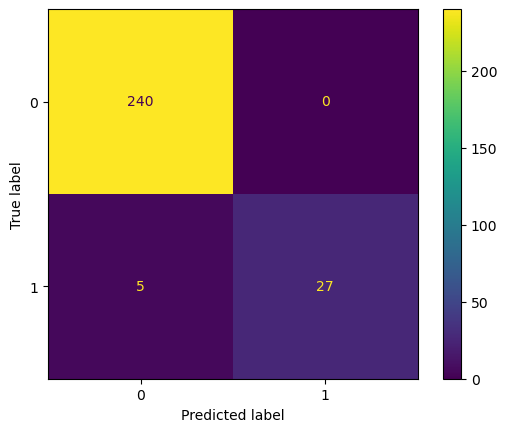

Average K-fold accuracy: 0.9629510825982358 +- 0.0237068473379529
Test Accuracy: 1.0
Test classification report:
              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00        60
         1.0       1.00      1.00      1.00         8

    accuracy                           1.00        68
   macro avg       1.00      1.00      1.00        68
weighted avg       1.00      1.00      1.00        68



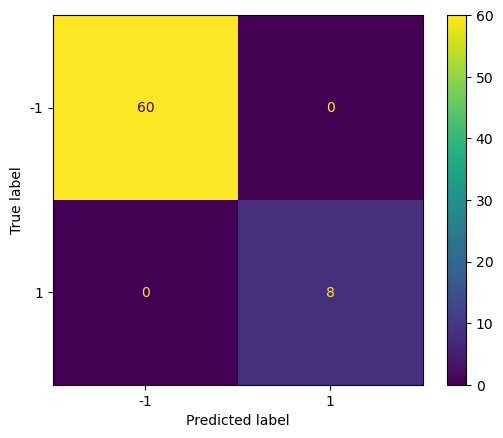

In [51]:
# IF
# val
isol_forest_A_1, isol_forest_params_A_1, stat = CV_train_isolation_forest(X_train, y_train, X_val, y_val, 5)
print('Average K-fold accuracy:', np.mean(stat),'+-', np.std(stat))

acc_isol_forest_A_1, precision_isol_forest_A_1, recall_isol_forest_A_1, f1_isol_forest_A_1 = evaluate_model(isol_forest_A_1, X_test, y_test)

# 1b) One-symbol images + PCA

Explained variance percentage = 1.0000000000000002
The number of records in the training dataset is 160 #-1: 0  #1: 160
The number of records in the validation dataset is 272 #-1: 240  #1: 32
The number of records in the testing dataset is 68 #-1: 60  #1: 8


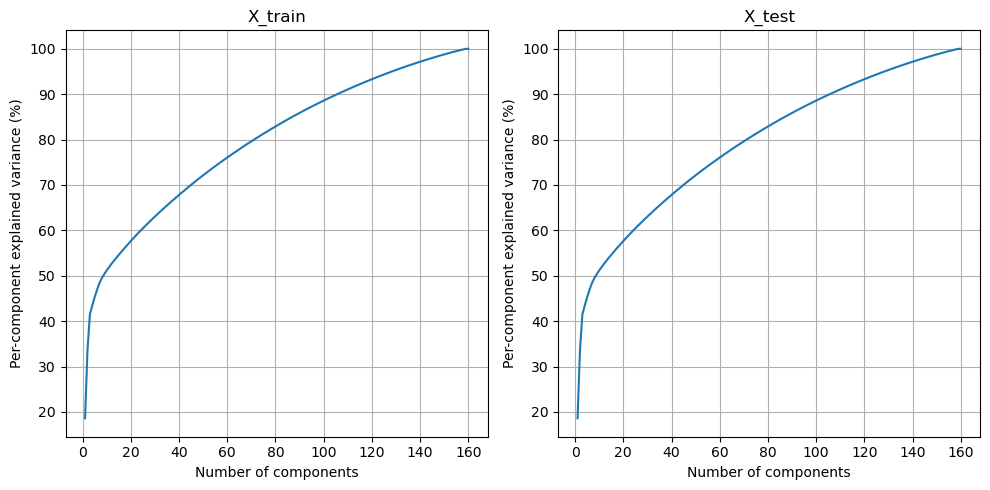

In [52]:
X_train, X_val, X_test, y_train, y_val, y_test  = Train_test_val_split(norm1_flat_1, norm2_flat_1, fault1_flat_1, fault2_flat_1, fault3_flat_1, use_pca = True)

Testing hyperparameters: nu: 0.01, kernel: rbf, gamma: scale
score 0.750120288692863
Testing hyperparameters: nu: 0.01, kernel: rbf, gamma: auto
score 0.5555199144613739
Testing hyperparameters: nu: 0.01, kernel: sigmoid, gamma: scale
score 0.3931301790964983
Testing hyperparameters: nu: 0.01, kernel: sigmoid, gamma: auto
score 0.4838545843357391
Testing hyperparameters: nu: 0.01, kernel: linear, gamma: scale
score 0.469473402833467
Testing hyperparameters: nu: 0.01, kernel: linear, gamma: auto
score 0.469473402833467
Testing hyperparameters: nu: 0.2, kernel: rbf, gamma: scale
score 0.8010425020048115
Testing hyperparameters: nu: 0.2, kernel: rbf, gamma: auto
score 0.5555199144613739
Testing hyperparameters: nu: 0.2, kernel: sigmoid, gamma: scale
score 0.12739909115209835
Testing hyperparameters: nu: 0.2, kernel: sigmoid, gamma: auto
score 0.39123229083132854
Testing hyperparameters: nu: 0.2, kernel: linear, gamma: scale
score 0.469473402833467
Testing hyperparameters: nu: 0.2, kernel:

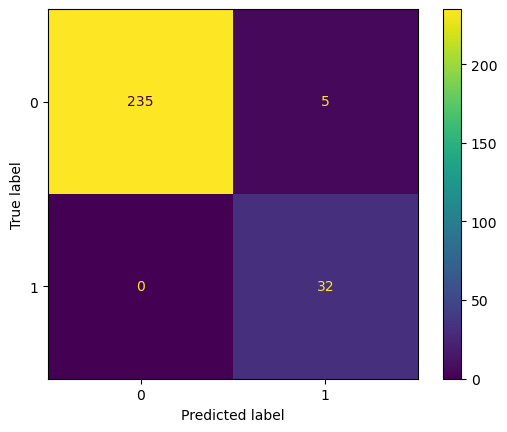

Average K-fold accuracy: 0.8010425020048115 +- 0.035465120686355725
Test Accuracy: 0.9705882352941176
Test classification report:
              precision    recall  f1-score   support

        -1.0       1.00      0.97      0.98        60
         1.0       0.80      1.00      0.89         8

    accuracy                           0.97        68
   macro avg       0.90      0.98      0.94        68
weighted avg       0.98      0.97      0.97        68



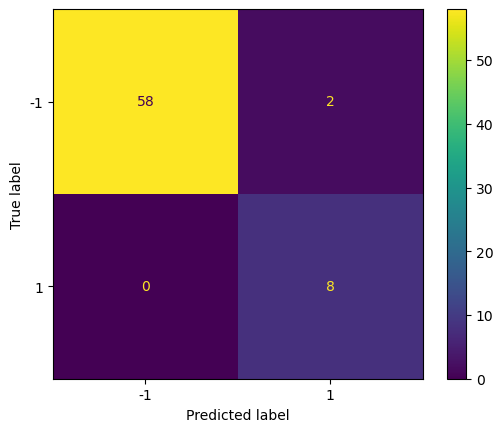

In [53]:
# OC_SVM
# val
one_class_svm_1, one_class_svm_params_1, stat = CV_one_class_svm(X_train, y_train, X_val, y_val, 5)
print('Average K-fold accuracy:', np.mean(stat),'+-', np.std(stat))

acc_one_class_svm_pca_1, precision_one_class_svm_pca_1, recall_one_class_svm_pca_1, f1_one_class_svm_pca_1 = evaluate_model(one_class_svm_1, X_test, y_test)

Testing hyperparameters: n_estimators: 50, max_samples: 10, contamination: 0.1
score 0.40978348035284684
Testing hyperparameters: n_estimators: 50, max_samples: 10, contamination: 0.3
score 0.32862870890136325
Testing hyperparameters: n_estimators: 50, max_samples: 50, contamination: 0.1
score 0.40513231756214907
Testing hyperparameters: n_estimators: 50, max_samples: 50, contamination: 0.3
score 0.3333333333333333
Testing hyperparameters: n_estimators: 50, max_samples: 100, contamination: 0.1
score 0.3865009355787223
Testing hyperparameters: n_estimators: 50, max_samples: 100, contamination: 0.3
score 0.2893076717455226
Testing hyperparameters: n_estimators: 75, max_samples: 10, contamination: 0.1
score 0.39582999198075386
Testing hyperparameters: n_estimators: 75, max_samples: 10, contamination: 0.3
score 0.3794439989307672
Testing hyperparameters: n_estimators: 75, max_samples: 50, contamination: 0.1
score 0.41440791232290836
Testing hyperparameters: n_estimators: 75, max_samples: 5

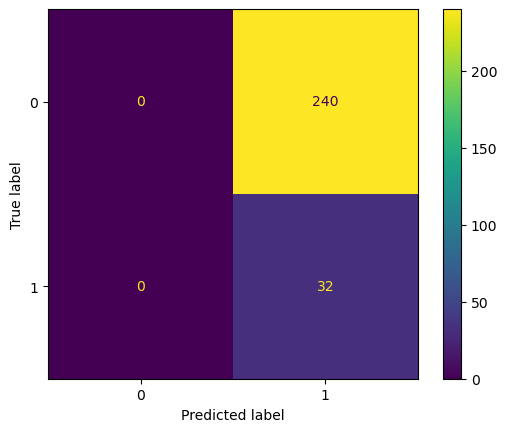

Average K-fold accuracy: 0.4236567762630313 +- 0.025589703737495303
Test Accuracy: 0.11764705882352941
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00        60
         1.0       0.12      1.00      0.21         8

    accuracy                           0.12        68
   macro avg       0.06      0.50      0.11        68
weighted avg       0.01      0.12      0.02        68



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

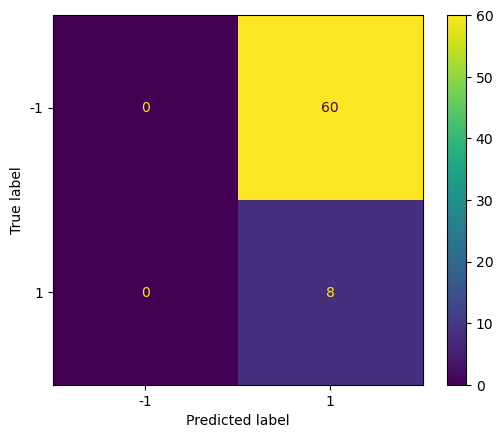

In [54]:
# IF
# val
isol_forest_1, isol_forest_params_1, stat = CV_train_isolation_forest(X_train, y_train, X_val, y_val, 5)
print('Average K-fold accuracy:', np.mean(stat),'+-', np.std(stat))

acc_isol_forest_pca_1, precision_isol_forest_pca_1, recall_isol_forest_pca_1, f1_isol_forest_pca_1 = evaluate_model(isol_forest_1, X_test, y_test)

# 4b) Transfer Learning - one-symbol images¶

In [55]:
# DOMAIN A
images_norm1_1, img_shape = load_visualize(path_norm1, 'Normal1', one_symbol = True)
ind = random.sample(range(images_norm1_1.shape[0]),100)
images_norm1_1 = images_norm1_1[ind, :, :]
images_norm2_1, _ = load_visualize(path_norm2, 'Normal2', one_symbol = True)
images_norm2_1 = images_norm2_1[ind, :, :]

images_fault_50_1, _ = load_visualize(path_fault_50, 'Faulty1', one_symbol = True)
images_fault_50_1 = images_fault_50_1[ind, :, :]
images_fault_43_1, _ = load_visualize(path_fault_43, 'Faulty2', one_symbol = True)
images_fault_43_1 = images_fault_43_1[ind, :, :]
images_fault_37_1, _ = load_visualize(path_fault_37, 'Faulty3', one_symbol = True)
images_fault_37_1 = images_fault_37_1[ind, :, :]

# flatten each image
norm2_flat = flatten_normalize(images_norm1_1, img_shape)
norm1_flat = flatten_normalize(images_norm2_1, img_shape)

fault1_flat = flatten_normalize(images_fault_50_1, img_shape)
fault2_flat = flatten_normalize(images_fault_43_1, img_shape)
fault3_flat = flatten_normalize(images_fault_37_1, img_shape)

X_train_A, X_val_A, X_test_A, y_train_A, y_val_A, y_test_A  = Train_test_val_split(norm1_flat_1, norm2_flat_1, fault1_flat_1, fault2_flat_1, fault3_flat_1)

------------Normal1---------------
Number of imges:  1600
Image size:  (142, 142)
------------Normal2---------------
Number of imges:  1600
Image size:  (142, 142)
------------Faulty1---------------
Number of imges:  1600
Image size:  (142, 142)
------------Faulty2---------------
Number of imges:  1600
Image size:  (142, 142)
------------Faulty3---------------
Number of imges:  1600
Image size:  (142, 142)
(100, 20164)
(100, 20164)
(100, 20164)
(100, 20164)
(100, 20164)
The number of records in the training dataset is 160 #-1: 0  #1: 160
The number of records in the validation dataset is 272 #-1: 240  #1: 32
The number of records in the testing dataset is 68 #-1: 60  #1: 8


In [56]:
# DOMAIN B

images_norm1_1, img_shape = load_visualize(path_norm1_b, 'Normal1', one_symbol = True)
images_norm1_1 = images_norm1_1[ind, :, :]
images_norm2_1, _ = load_visualize(path_norm2_b, 'Normal2', one_symbol = True)
images_norm2_1 = images_norm2_1[ind, :, :]

images_fault_50_1, _ = load_visualize(path_fault_50_b, 'Faulty1', one_symbol = True)
images_fault_50_1 = images_fault_50_1[ind, :, :]
images_fault_43_1, _ = load_visualize(path_fault_43_b, 'Faulty2', one_symbol = True)
images_fault_43_1 = images_fault_43_1[ind, :, :]
images_fault_37_1, _ = load_visualize(path_fault_37_b, 'Faulty3', one_symbol = True)
images_fault_37_1 = images_fault_37_1[ind, :, :]


# flatten each image
norm2_flat = flatten_normalize(images_norm1_1, img_shape)
norm1_flat = flatten_normalize(images_norm2_1, img_shape)

fault1_flat = flatten_normalize(images_fault_50_1, img_shape)
fault2_flat = flatten_normalize(images_fault_43_1, img_shape)
fault3_flat = flatten_normalize(images_fault_37_1, img_shape)


normal = np.vstack((norm1_flat, norm2_flat)) # stack good classes 
labels_normal = np.ones(shape = normal.shape[0])

faulty = np.vstack((fault1_flat, fault2_flat, fault3_flat)) # stack good classes 
labels_faulty = -1 * np.ones(shape = faulty.shape[0])

normal_train, normal_test, labels_normal_train, labels_normal_test = train_test_split(normal, labels_normal, test_size=0.2, random_state=42)

X_train_B, y_train_B = normal_train, labels_normal_train
X_test_B, y_test_B = np.vstack((normal_test, faulty)), np.concatenate((labels_normal_test, labels_faulty))

print('The number of records in the training dataset is', X_train_B.shape[0],'#-1:', np.where(y_train_B == -1)[0].shape[0],' #1:', np.where(y_train_B == 1)[0].shape[0]) 
print('The number of records in the testing dataset is', X_test_B.shape[0],'#-1:', np.where(y_test_B == -1)[0].shape[0],' #1:', np.where(y_test_B == 1)[0].shape[0])    

------------Normal1---------------
Number of imges:  1600
Image size:  (142, 142)
------------Normal2---------------
Number of imges:  1600
Image size:  (142, 142)
------------Faulty1---------------
Number of imges:  1600
Image size:  (142, 142)
------------Faulty2---------------
Number of imges:  1600
Image size:  (142, 142)
------------Faulty3---------------
Number of imges:  1600
Image size:  (142, 142)
(100, 20164)
(100, 20164)
(100, 20164)
(100, 20164)
(100, 20164)
The number of records in the training dataset is 160 #-1: 0  #1: 160
The number of records in the testing dataset is 340 #-1: 300  #1: 40


In [57]:
#oc svm

Test Accuracy: 0.9205882352941176
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.92      1.00      0.96       300
         1.0       1.00      0.33      0.49        40

    accuracy                           0.92       340
   macro avg       0.96      0.66      0.72       340
weighted avg       0.93      0.92      0.90       340



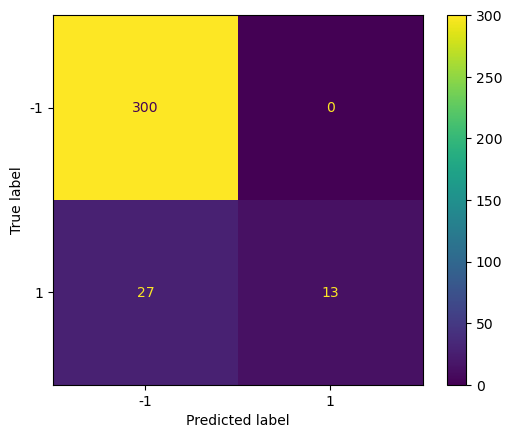

In [58]:
# a Pure TL
acc_oc_svm_AB_1, precision_oc_svm_AB_1, recall_oc_svm_AB_1, f1_oc_svm_AB_1 = evaluate_model(one_class_svm_A_1, X_test_B, y_test_B)

Test Accuracy: 1.0
Test classification report:
              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00       300
         1.0       1.00      1.00      1.00        40

    accuracy                           1.00       340
   macro avg       1.00      1.00      1.00       340
weighted avg       1.00      1.00      1.00       340



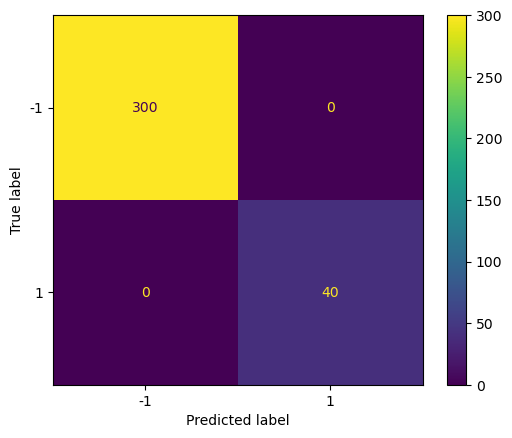

In [59]:
# b from scratch trained on domain b
one_class_svm_B_1 = OneClassSVM(nu=one_class_svm_params_A_1['nu'], kernel = one_class_svm_params_A_1['kernel'], 
                             gamma = one_class_svm_params_A_1['gamma'])
one_class_svm_B_1.fit(X_train_B, y_train_B) 
acc_oc_svm_BB_1, precision_oc_svm_BB_1, recall_oc_svm_BB_1, f1_oc_svm_BB_1 = evaluate_model(one_class_svm_B_1, X_test_B, y_test_B)

10
Test Accuracy: 0.9411764705882353
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.94      1.00      0.97       300
         1.0       1.00      0.50      0.67        40

    accuracy                           0.94       340
   macro avg       0.97      0.75      0.82       340
weighted avg       0.94      0.94      0.93       340



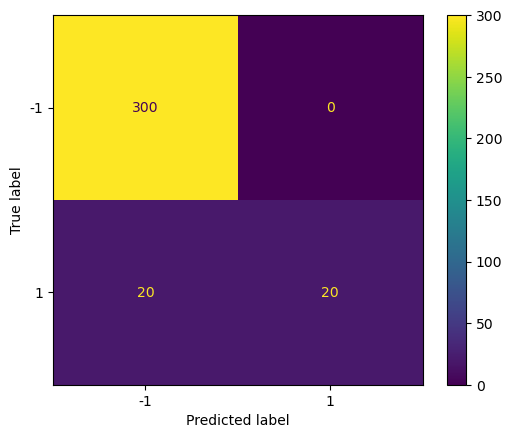

10
Test Accuracy: 0.9441176470588235
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.94      1.00      0.97       300
         1.0       1.00      0.53      0.69        40

    accuracy                           0.94       340
   macro avg       0.97      0.76      0.83       340
weighted avg       0.95      0.94      0.94       340



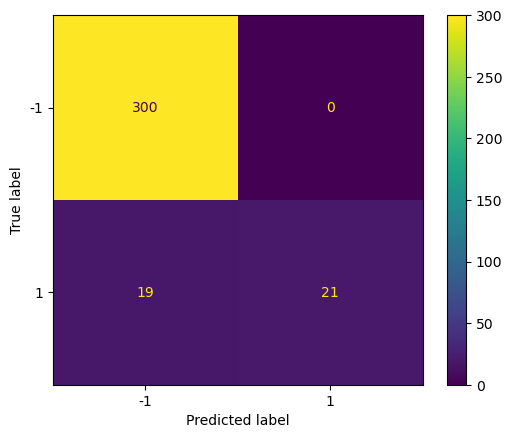

10
Test Accuracy: 0.9470588235294117
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.94      1.00      0.97       300
         1.0       1.00      0.55      0.71        40

    accuracy                           0.95       340
   macro avg       0.97      0.78      0.84       340
weighted avg       0.95      0.95      0.94       340



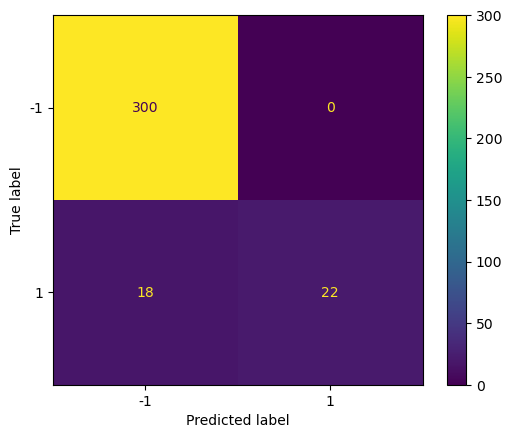

10
Test Accuracy: 0.9294117647058824
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.93      1.00      0.96       300
         1.0       1.00      0.40      0.57        40

    accuracy                           0.93       340
   macro avg       0.96      0.70      0.77       340
weighted avg       0.93      0.93      0.92       340



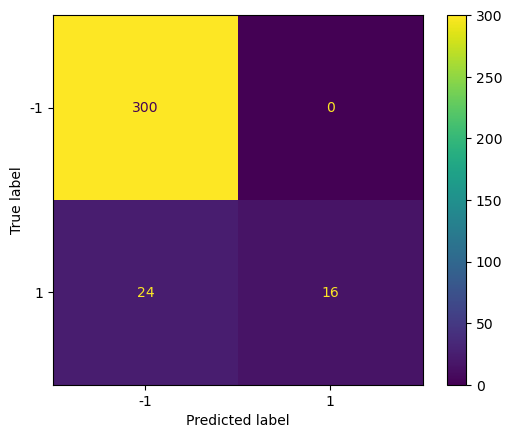

10
Test Accuracy: 0.9352941176470588
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.93      1.00      0.96       300
         1.0       1.00      0.45      0.62        40

    accuracy                           0.94       340
   macro avg       0.97      0.72      0.79       340
weighted avg       0.94      0.94      0.92       340



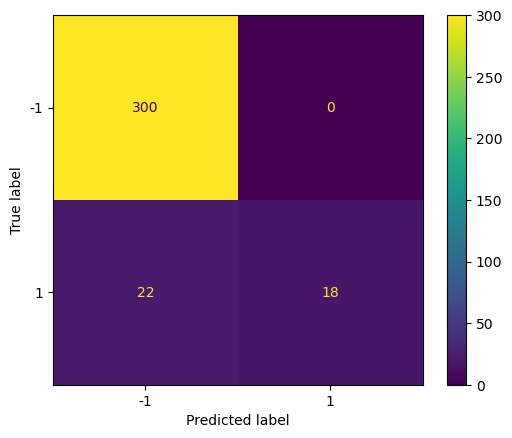

10
Test Accuracy: 0.9529411764705882
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.95      1.00      0.97       300
         1.0       1.00      0.60      0.75        40

    accuracy                           0.95       340
   macro avg       0.97      0.80      0.86       340
weighted avg       0.96      0.95      0.95       340



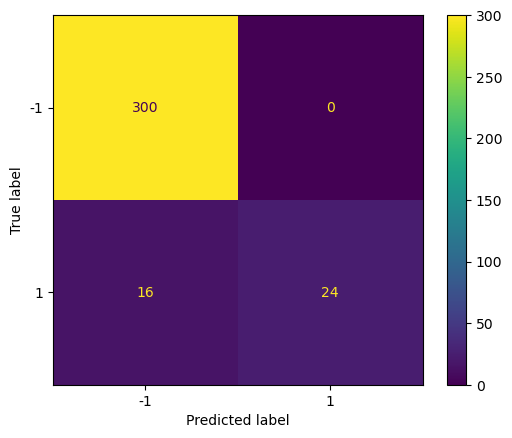

10
Test Accuracy: 0.9382352941176471
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.93      1.00      0.97       300
         1.0       1.00      0.47      0.64        40

    accuracy                           0.94       340
   macro avg       0.97      0.74      0.81       340
weighted avg       0.94      0.94      0.93       340



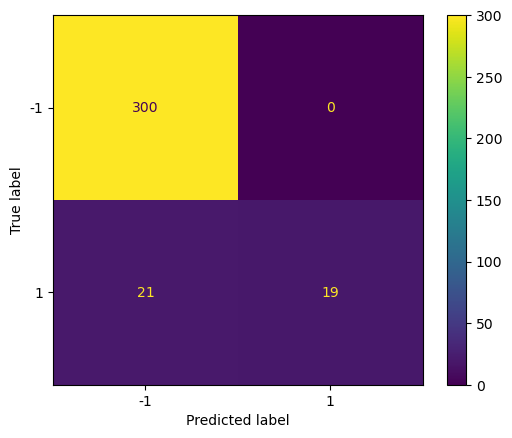

10
Test Accuracy: 0.9264705882352942
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.92      1.00      0.96       300
         1.0       1.00      0.38      0.55        40

    accuracy                           0.93       340
   macro avg       0.96      0.69      0.75       340
weighted avg       0.93      0.93      0.91       340



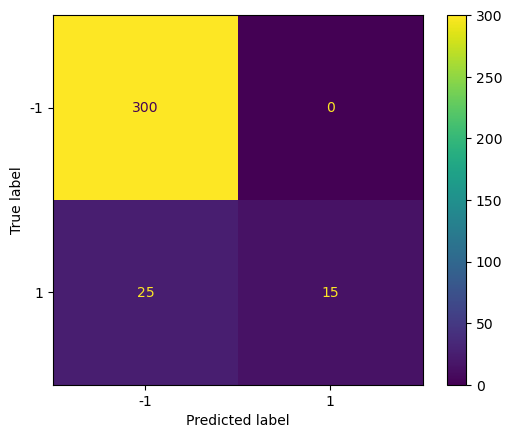

10
Test Accuracy: 0.9294117647058824
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.93      1.00      0.96       300
         1.0       1.00      0.40      0.57        40

    accuracy                           0.93       340
   macro avg       0.96      0.70      0.77       340
weighted avg       0.93      0.93      0.92       340



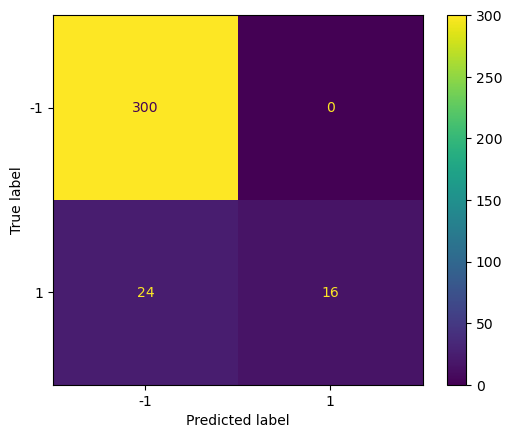

10
Test Accuracy: 0.9529411764705882
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.95      1.00      0.97       300
         1.0       1.00      0.60      0.75        40

    accuracy                           0.95       340
   macro avg       0.97      0.80      0.86       340
weighted avg       0.96      0.95      0.95       340



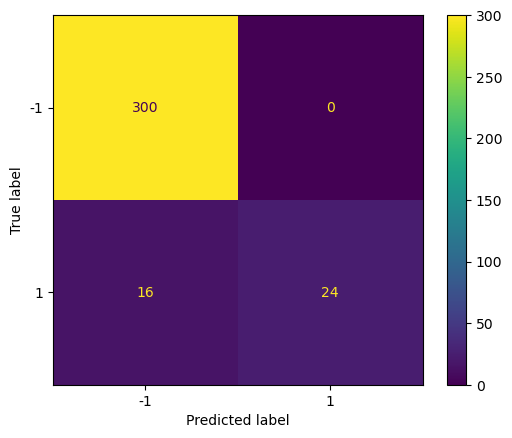

10
Test Accuracy: 0.9823529411764705
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.98      1.00      0.99       300
         1.0       1.00      0.85      0.92        40

    accuracy                           0.98       340
   macro avg       0.99      0.93      0.95       340
weighted avg       0.98      0.98      0.98       340



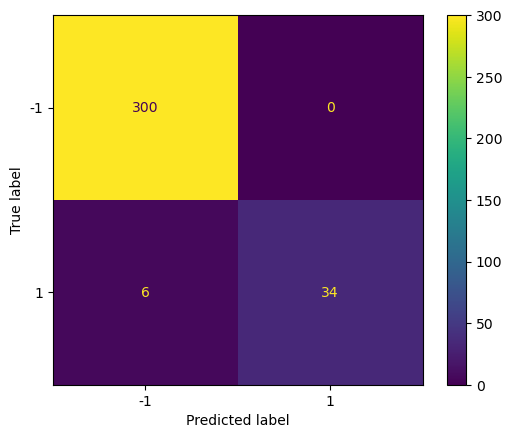

10
Test Accuracy: 0.9294117647058824
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.93      1.00      0.96       300
         1.0       1.00      0.40      0.57        40

    accuracy                           0.93       340
   macro avg       0.96      0.70      0.77       340
weighted avg       0.93      0.93      0.92       340



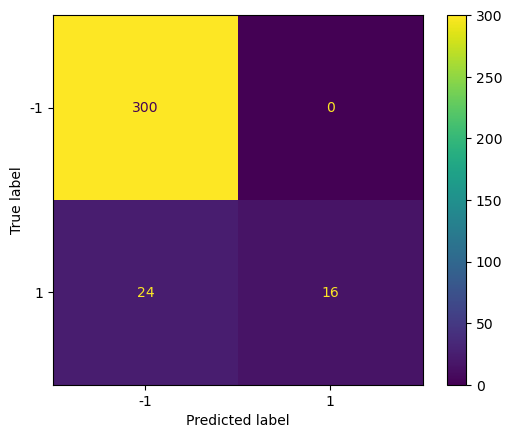

10
Test Accuracy: 0.9294117647058824
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.93      1.00      0.96       300
         1.0       1.00      0.40      0.57        40

    accuracy                           0.93       340
   macro avg       0.96      0.70      0.77       340
weighted avg       0.93      0.93      0.92       340



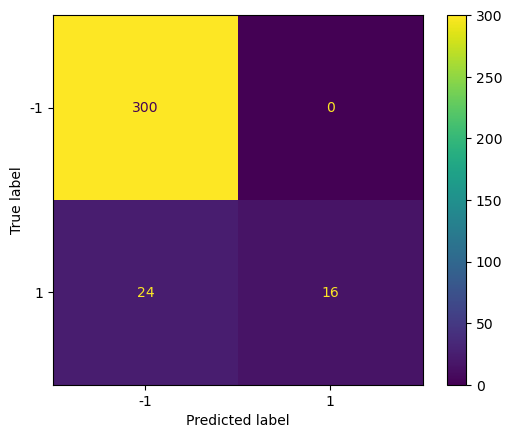

10
Test Accuracy: 0.9323529411764706
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.93      1.00      0.96       300
         1.0       1.00      0.42      0.60        40

    accuracy                           0.93       340
   macro avg       0.96      0.71      0.78       340
weighted avg       0.94      0.93      0.92       340



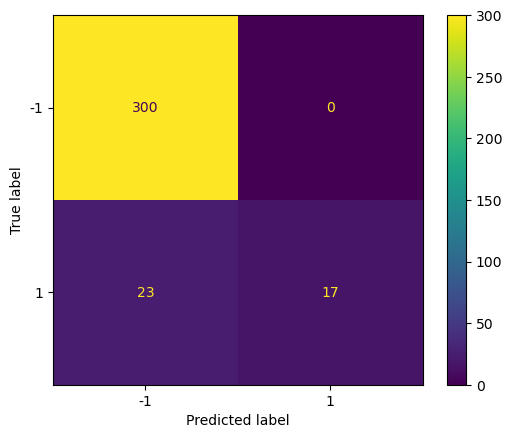

10
Test Accuracy: 0.9235294117647059
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.92      1.00      0.96       300
         1.0       1.00      0.35      0.52        40

    accuracy                           0.92       340
   macro avg       0.96      0.68      0.74       340
weighted avg       0.93      0.92      0.91       340



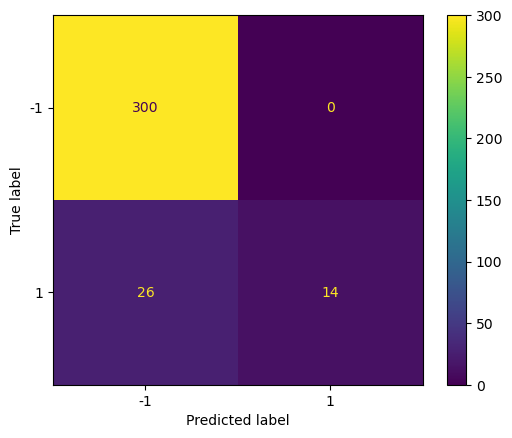

10
Test Accuracy: 0.9294117647058824
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.93      1.00      0.96       300
         1.0       1.00      0.40      0.57        40

    accuracy                           0.93       340
   macro avg       0.96      0.70      0.77       340
weighted avg       0.93      0.93      0.92       340



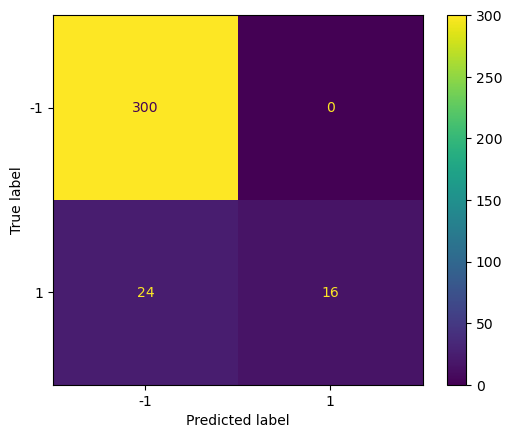

In [60]:
# c Domain adaptation
oc_svm_metric_lists_1=[]
for batch, batch_labels in zip(np.split(X_train_B, 16), np.split(y_train_B, 16)):
    print(batch.shape[0])
    one_class_svm_A_1.fit(batch, batch_labels)
    metric_list = evaluate_model(one_class_svm_A_1, X_test_B, y_test_B , return_list = True)
    oc_svm_metric_lists_1.append(metric_list)

In [61]:
# isol forest

Test Accuracy: 0.9088235294117647
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.91      1.00      0.95       300
         1.0       1.00      0.23      0.37        40

    accuracy                           0.91       340
   macro avg       0.95      0.61      0.66       340
weighted avg       0.92      0.91      0.88       340



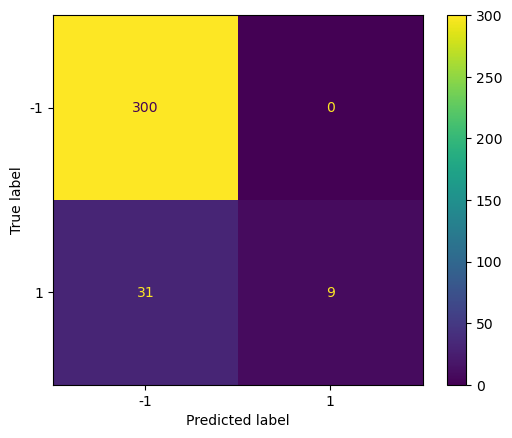

In [62]:
# a Pure TL
acc_isol_forest_AB_1, precision_isol_forest_AB_1, recall_isol_forest_AB_1, f1_isol_forest_AB_1 = evaluate_model(isol_forest_A_1, X_test_B, y_test_B)

Test Accuracy: 0.9911764705882353
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.99      1.00      1.00       300
         1.0       1.00      0.93      0.96        40

    accuracy                           0.99       340
   macro avg       1.00      0.96      0.98       340
weighted avg       0.99      0.99      0.99       340



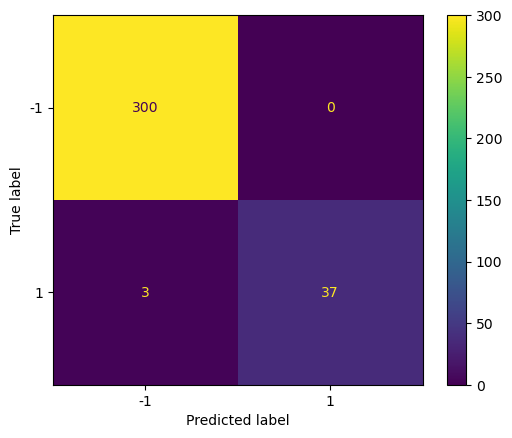

In [63]:
# b from scratch trained on domain b
isol_forest_B_1 = IsolationForest(n_estimators=isol_forest_params_A_1['n_estimators'], max_samples=isol_forest_params_A_1['max_samples'], 
                                contamination=isol_forest_params_A_1['contamination'])
isol_forest_B_1.fit(X_train_B) 
acc_isol_forest_BB_1, precision_isol_forest_BB_1, recall_isol_forest_BB_1, f1_isol_forest_BB_1 = evaluate_model(isol_forest_B_1, X_test_B, y_test_B)

10


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_iforest.py:307: UserWarning: max_samples (50) is greater than the total number of samples (10). max_samples will be set to n_samples for estimation.
  warn(


Test Accuracy: 0.9735294117647059
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.99      0.98      0.98       300
         1.0       0.86      0.93      0.89        40

    accuracy                           0.97       340
   macro avg       0.93      0.95      0.94       340
weighted avg       0.97      0.97      0.97       340



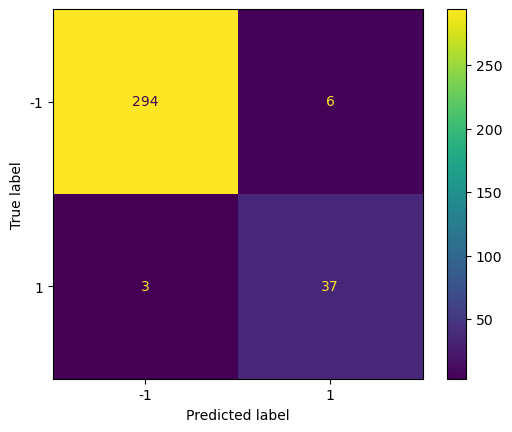

10


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_iforest.py:307: UserWarning: max_samples (50) is greater than the total number of samples (10). max_samples will be set to n_samples for estimation.
  warn(


Test Accuracy: 0.9941176470588236
Test classification report:
              precision    recall  f1-score   support

        -1.0       1.00      0.99      1.00       300
         1.0       0.95      1.00      0.98        40

    accuracy                           0.99       340
   macro avg       0.98      1.00      0.99       340
weighted avg       0.99      0.99      0.99       340



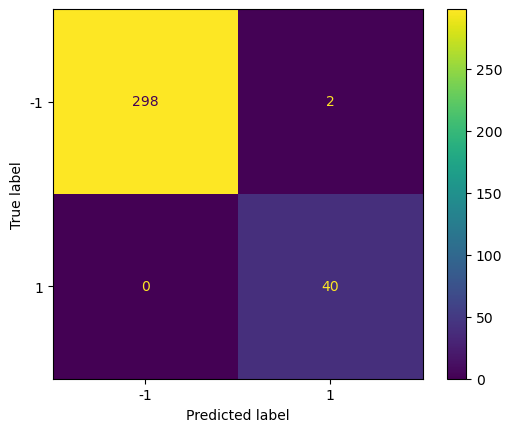

10


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_iforest.py:307: UserWarning: max_samples (50) is greater than the total number of samples (10). max_samples will be set to n_samples for estimation.
  warn(


Test Accuracy: 0.9735294117647059
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.97      1.00      0.99       300
         1.0       1.00      0.78      0.87        40

    accuracy                           0.97       340
   macro avg       0.99      0.89      0.93       340
weighted avg       0.97      0.97      0.97       340



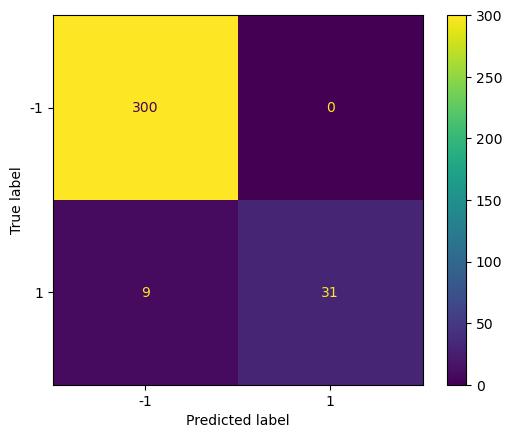

10


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_iforest.py:307: UserWarning: max_samples (50) is greater than the total number of samples (10). max_samples will be set to n_samples for estimation.
  warn(


Test Accuracy: 0.9882352941176471
Test classification report:
              precision    recall  f1-score   support

        -1.0       1.00      0.99      0.99       300
         1.0       0.91      1.00      0.95        40

    accuracy                           0.99       340
   macro avg       0.95      0.99      0.97       340
weighted avg       0.99      0.99      0.99       340



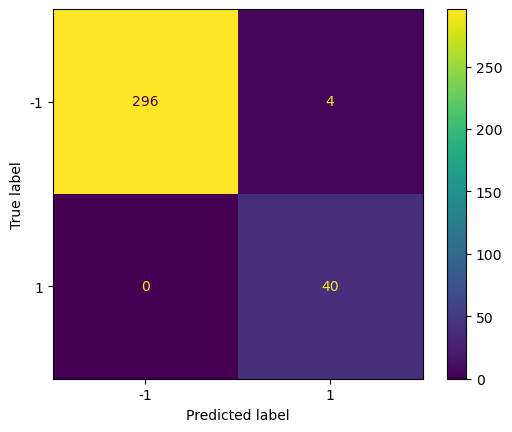

10


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_iforest.py:307: UserWarning: max_samples (50) is greater than the total number of samples (10). max_samples will be set to n_samples for estimation.
  warn(


Test Accuracy: 0.961764705882353
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.96      1.00      0.98       300
         1.0       1.00      0.68      0.81        40

    accuracy                           0.96       340
   macro avg       0.98      0.84      0.89       340
weighted avg       0.96      0.96      0.96       340



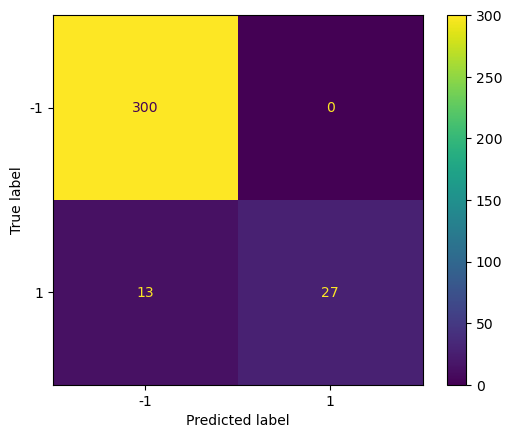

10


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_iforest.py:307: UserWarning: max_samples (50) is greater than the total number of samples (10). max_samples will be set to n_samples for estimation.
  warn(


Test Accuracy: 0.9852941176470589
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.98      1.00      0.99       300
         1.0       1.00      0.88      0.93        40

    accuracy                           0.99       340
   macro avg       0.99      0.94      0.96       340
weighted avg       0.99      0.99      0.98       340



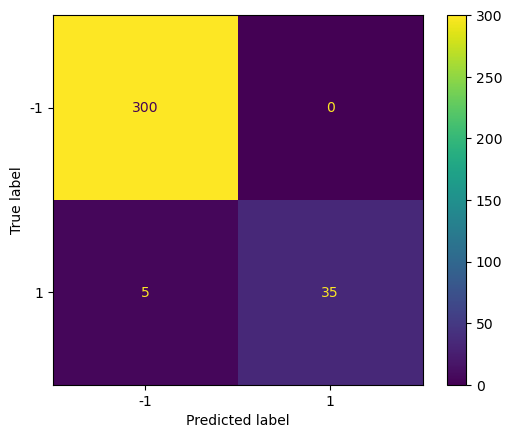

10


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_iforest.py:307: UserWarning: max_samples (50) is greater than the total number of samples (10). max_samples will be set to n_samples for estimation.
  warn(


Test Accuracy: 0.9352941176470588
Test classification report:
              precision    recall  f1-score   support

        -1.0       1.00      0.93      0.96       300
         1.0       0.65      1.00      0.78        40

    accuracy                           0.94       340
   macro avg       0.82      0.96      0.87       340
weighted avg       0.96      0.94      0.94       340



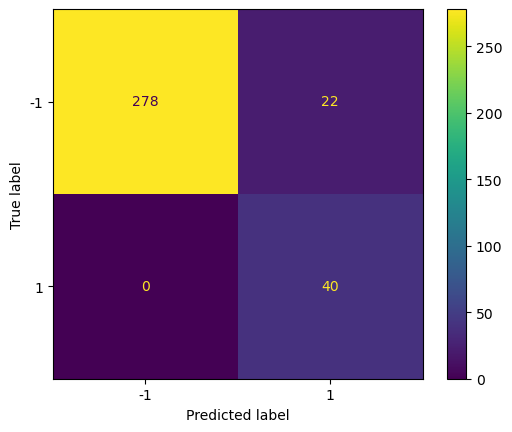

10


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_iforest.py:307: UserWarning: max_samples (50) is greater than the total number of samples (10). max_samples will be set to n_samples for estimation.
  warn(


Test Accuracy: 0.9911764705882353
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.99      1.00      1.00       300
         1.0       1.00      0.93      0.96        40

    accuracy                           0.99       340
   macro avg       1.00      0.96      0.98       340
weighted avg       0.99      0.99      0.99       340



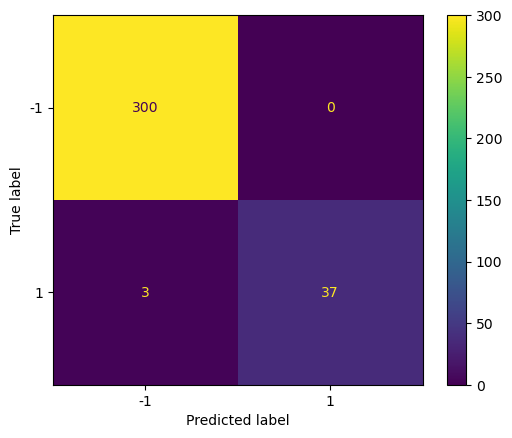

10


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_iforest.py:307: UserWarning: max_samples (50) is greater than the total number of samples (10). max_samples will be set to n_samples for estimation.
  warn(


Test Accuracy: 0.9794117647058823
Test classification report:
              precision    recall  f1-score   support

        -1.0       1.00      0.98      0.99       300
         1.0       0.87      0.97      0.92        40

    accuracy                           0.98       340
   macro avg       0.93      0.98      0.95       340
weighted avg       0.98      0.98      0.98       340



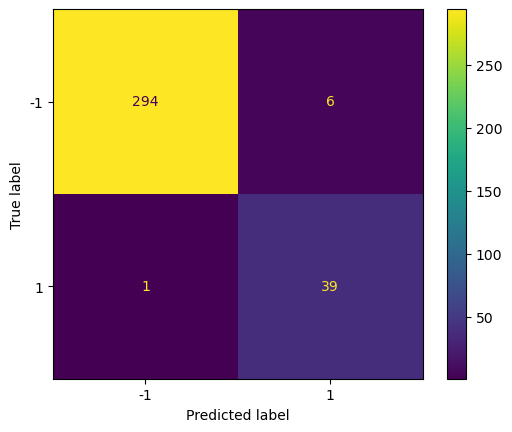

10


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_iforest.py:307: UserWarning: max_samples (50) is greater than the total number of samples (10). max_samples will be set to n_samples for estimation.
  warn(


Test Accuracy: 0.9794117647058823
Test classification report:
              precision    recall  f1-score   support

        -1.0       1.00      0.98      0.99       300
         1.0       0.85      1.00      0.92        40

    accuracy                           0.98       340
   macro avg       0.93      0.99      0.95       340
weighted avg       0.98      0.98      0.98       340



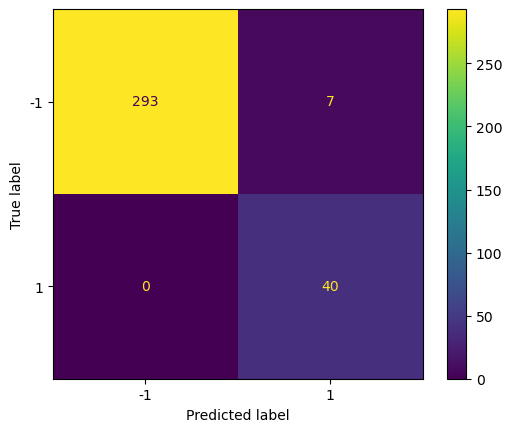

10


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_iforest.py:307: UserWarning: max_samples (50) is greater than the total number of samples (10). max_samples will be set to n_samples for estimation.
  warn(


Test Accuracy: 0.9735294117647059
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.99      0.98      0.98       300
         1.0       0.84      0.95      0.89        40

    accuracy                           0.97       340
   macro avg       0.92      0.96      0.94       340
weighted avg       0.98      0.97      0.97       340



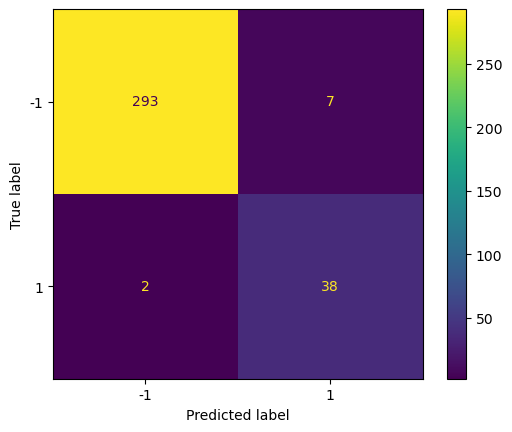

10


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_iforest.py:307: UserWarning: max_samples (50) is greater than the total number of samples (10). max_samples will be set to n_samples for estimation.
  warn(


Test Accuracy: 0.9823529411764705
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.99      0.99      0.99       300
         1.0       0.95      0.90      0.92        40

    accuracy                           0.98       340
   macro avg       0.97      0.95      0.96       340
weighted avg       0.98      0.98      0.98       340



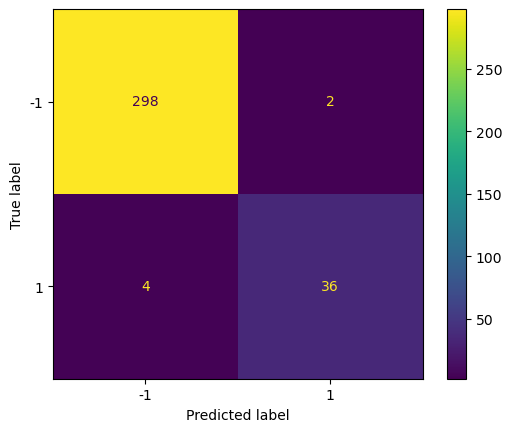

10


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_iforest.py:307: UserWarning: max_samples (50) is greater than the total number of samples (10). max_samples will be set to n_samples for estimation.
  warn(


Test Accuracy: 0.9705882352941176
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.99      0.98      0.98       300
         1.0       0.86      0.90      0.88        40

    accuracy                           0.97       340
   macro avg       0.92      0.94      0.93       340
weighted avg       0.97      0.97      0.97       340



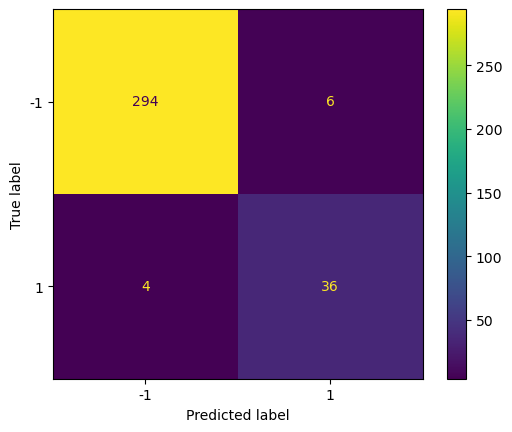

10


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_iforest.py:307: UserWarning: max_samples (50) is greater than the total number of samples (10). max_samples will be set to n_samples for estimation.
  warn(


Test Accuracy: 0.9970588235294118
Test classification report:
              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00       300
         1.0       1.00      0.97      0.99        40

    accuracy                           1.00       340
   macro avg       1.00      0.99      0.99       340
weighted avg       1.00      1.00      1.00       340



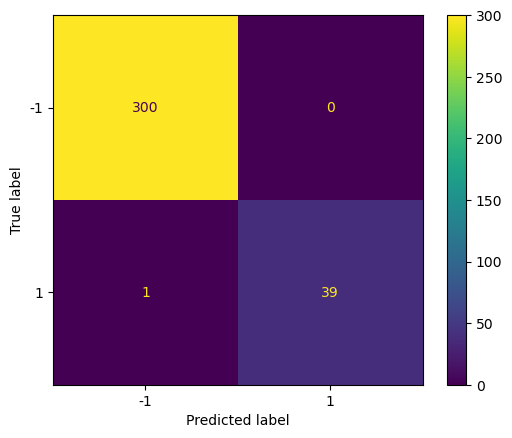

10


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_iforest.py:307: UserWarning: max_samples (50) is greater than the total number of samples (10). max_samples will be set to n_samples for estimation.
  warn(


Test Accuracy: 0.9558823529411765
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.96      0.99      0.98       300
         1.0       0.90      0.70      0.79        40

    accuracy                           0.96       340
   macro avg       0.93      0.84      0.88       340
weighted avg       0.95      0.96      0.95       340



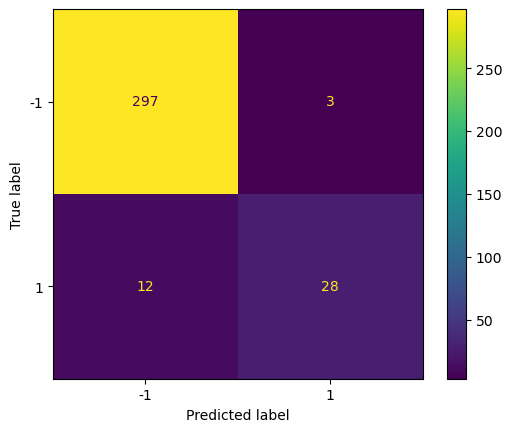

10


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_iforest.py:307: UserWarning: max_samples (50) is greater than the total number of samples (10). max_samples will be set to n_samples for estimation.
  warn(


Test Accuracy: 0.9352941176470588
Test classification report:
              precision    recall  f1-score   support

        -1.0       0.98      0.94      0.96       300
         1.0       0.67      0.88      0.76        40

    accuracy                           0.94       340
   macro avg       0.83      0.91      0.86       340
weighted avg       0.95      0.94      0.94       340



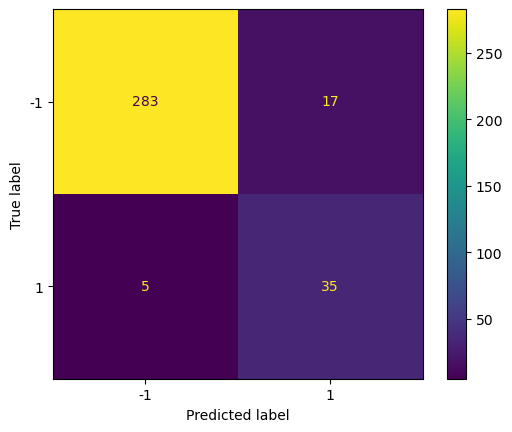

In [64]:
# c Domain adaptation
isol_forest_metric_lists_1=[]
for batch, batch_labels in zip(np.split(X_train_B, 16), np.split(y_train_B, 16)):
    print(batch.shape[0])
    isol_forest_A_1.fit(batch)
    metric_list = evaluate_model(isol_forest_A_1, X_test_B, y_test_B, return_list=True)
    isol_forest_metric_lists_1.append(metric_list)

# 5) PLOTS

In [65]:
# Lists of classification metrics - original & resized & cropped images
accuracies_oc_svm_1 = [acc_oc_svm_A_1, acc_one_class_svm_pca_1] 
precisions_oc_svm_1 = [precision_oc_svm_A_1, precision_one_class_svm_pca_1]
recalls_oc_svm_1 = [recall_oc_svm_A_1, recall_one_class_svm_pca_1]
f1s_oc_svm_1 = [f1_oc_svm_A_1, f1_one_class_svm_pca_1]

accuracies_isol_forest_1 = [acc_isol_forest_A_1, acc_isol_forest_pca_1]
precisions_isol_forest_1 = [precision_isol_forest_A_1, precision_isol_forest_pca_1]
recalls_isol_forest_1 = [recall_isol_forest_A_1, recall_isol_forest_pca_1]
f1s_isol_forest_1 = [f1_isol_forest_A_1, f1_isol_forest_pca_1]

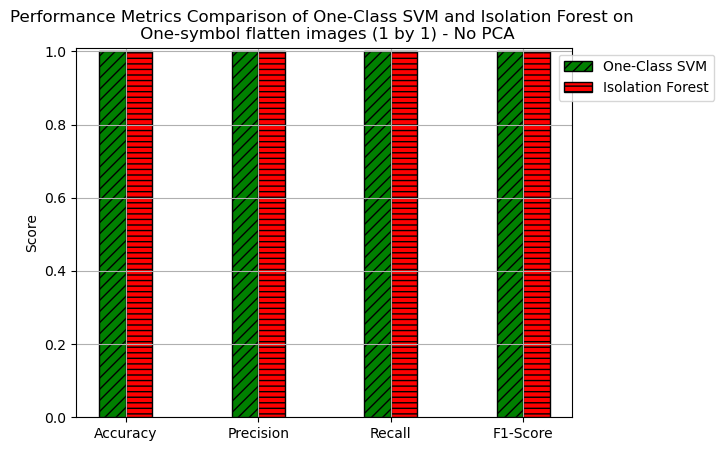

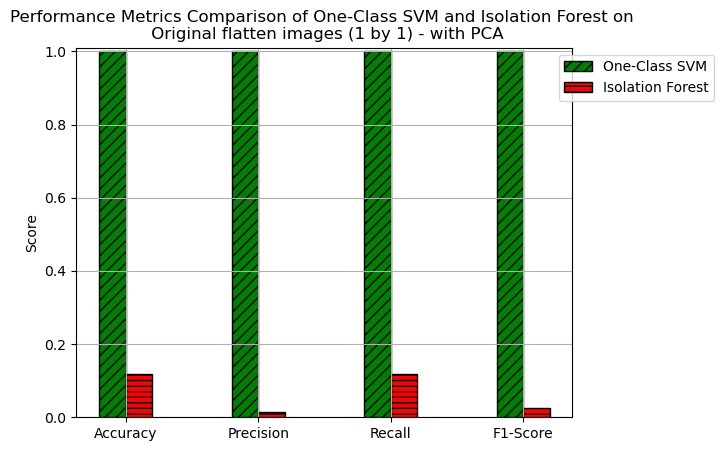

In [66]:

title_list = ["One-symbol flatten images (1 by 1) - No PCA" , "Original flatten images (1 by 1) - with PCA"]
#---------------plots---------------#
x_svm = np.arange(4)-0.1  # the x locations for the bars in global metrics plot
x_if = np.arange(4)+0.1  # the x locations for the bars in global metrics plot
#x2_svm = np.arange(6)-0.1  # the x locations for the bars in precision/recall/f1-score metrics plot
#x2K = np.arange(6)+0.1  # the x locations for the bars in precision/recall/f1-score metrics plot
w = 0.2       # the width of the bars

# 1) global metrics
for i in range(len(title_list)):
    plt.bar(x_svm, [accuracies_oc_svm[i], precisions_oc_svm[i], recalls_oc_svm[i], f1s_oc_svm[i]],
            width=w, edgecolor='black', color='g', align='center', hatch='///', label='One-Class SVM')
    plt.bar(x_if, [accuracies_isol_forest[i], precisions_isol_forest[i], recalls_isol_forest[i], f1s_isol_forest[i]],
            width=w, edgecolor='black', color='r', align='center', hatch='---', label='Isolation Forest')
    plt.xticks(x_svm + 0.1, ["Accuracy", "Precision", "Recall", "F1-Score"])
    plt.title('Performance Metrics Comparison of One-Class SVM and Isolation Forest on \n {}'.format(title_list[i]))
    plt.ylabel('Score')
    plt.ylim([0, 1.01])
    plt.grid()
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
    plt.show()



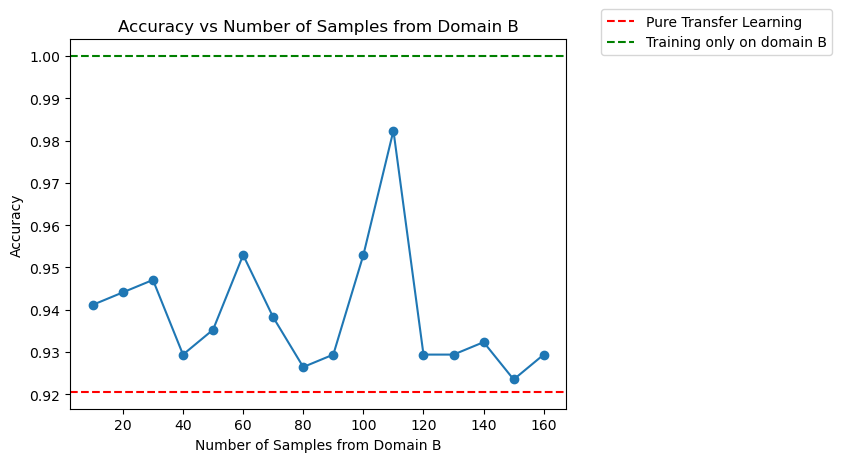

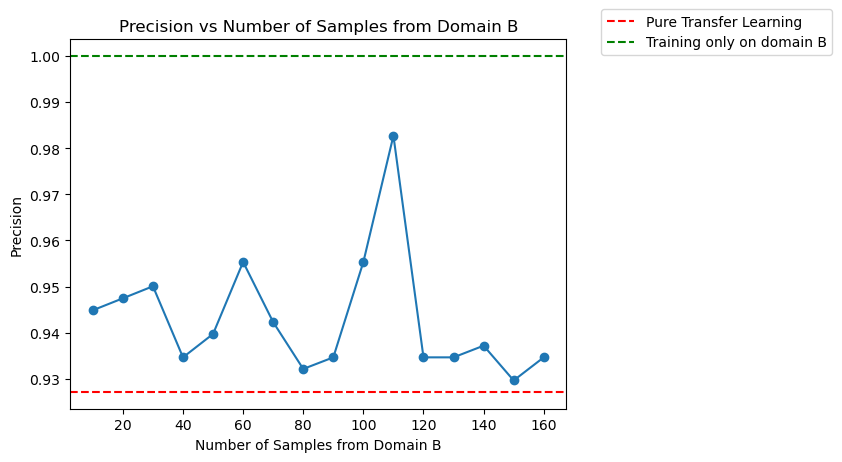

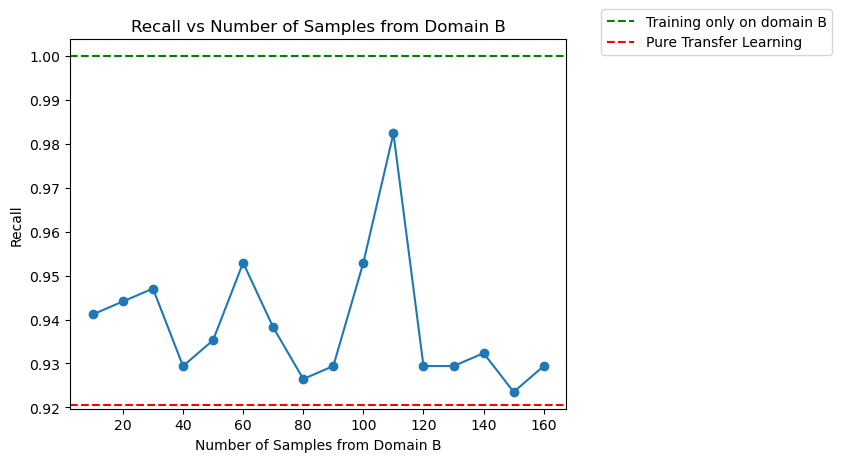

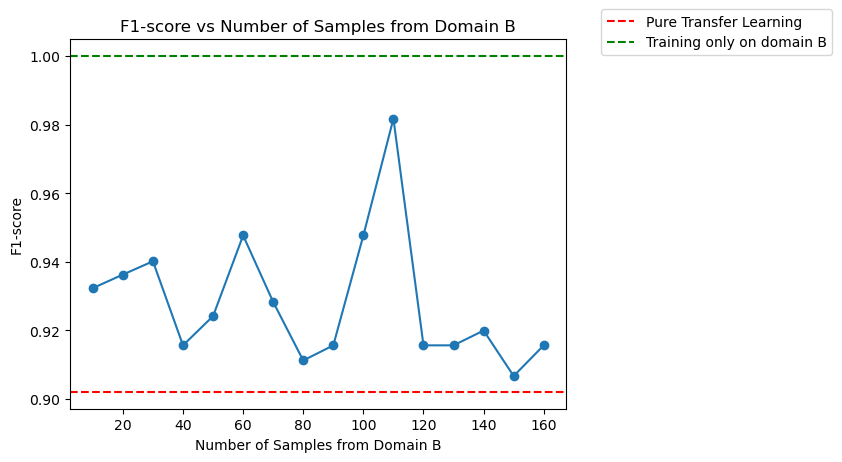

In [67]:
# TL plot - oc svm
oc_svm_pure_tl_1 = [acc_oc_svm_AB_1, precision_oc_svm_AB_1, recall_oc_svm_AB_1, f1_oc_svm_AB_1]
oc_svm_allb_tl_1 = [acc_oc_svm_BB_1, precision_oc_svm_BB_1, recall_oc_svm_BB_1, f1_oc_svm_BB_1]
plot_tl(oc_svm_metric_lists_1, oc_svm_pure_tl_1, oc_svm_allb_tl_1, batch_size = batch.shape[0])

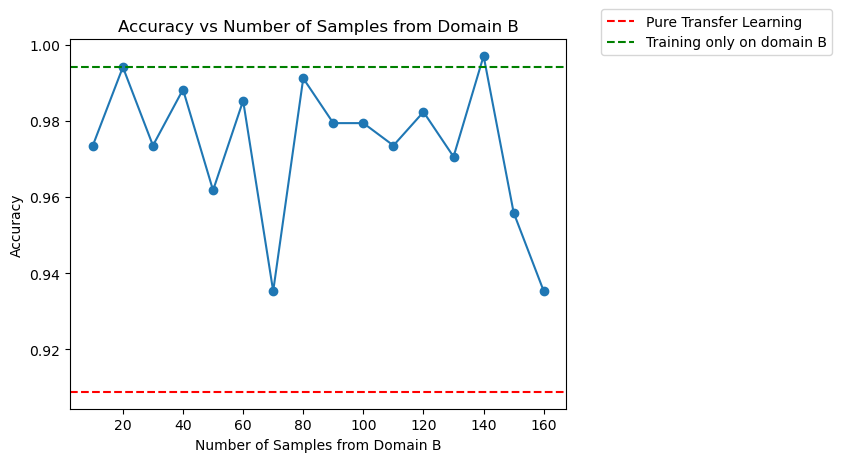

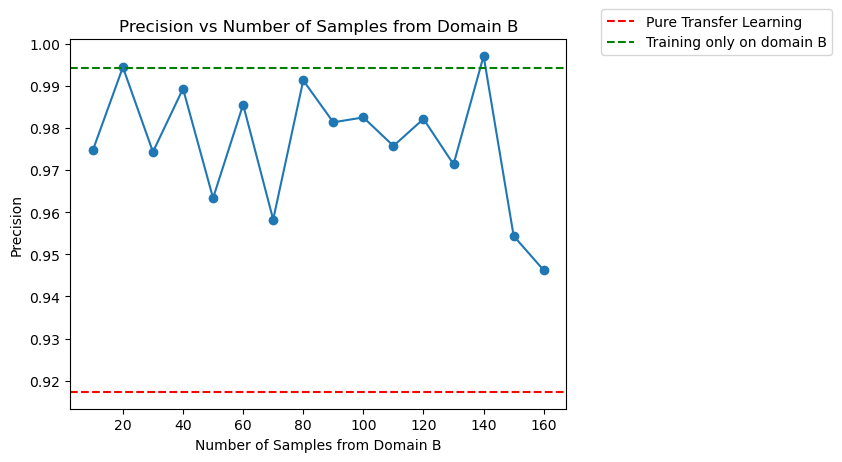

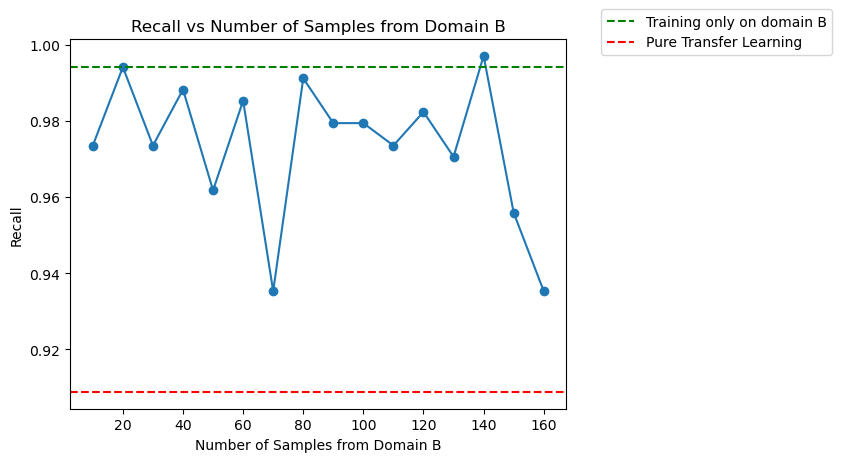

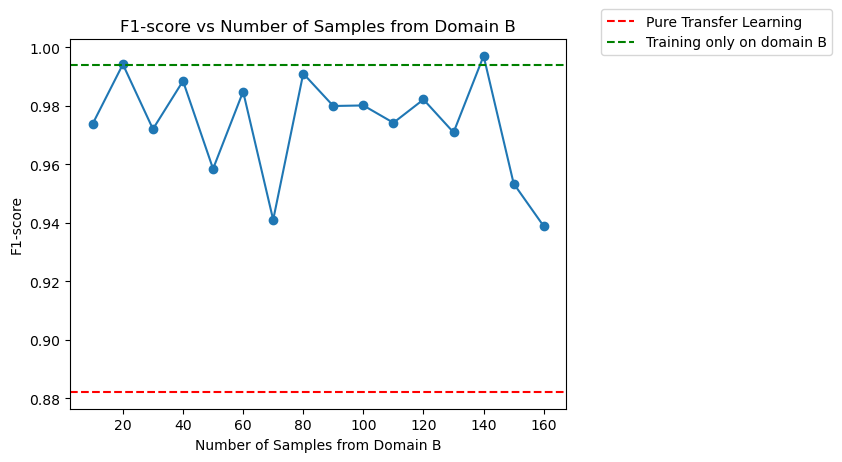

In [68]:
# TL plot - IF
isol_forest_pure_tl_1 = [acc_isol_forest_AB_1, precision_isol_forest_AB_1, recall_isol_forest_AB_1, f1_isol_forest_AB_1]
isol_forest_allb_tl_1 = [acc_isol_forest_BB_1, precision_isol_forest_BB_1, recall_isol_forest_BB_1, f1_isol_forest_BB_1]
plot_tl(isol_forest_metric_lists_1, isol_forest_pure_tl_1, isol_forest_allb_tl, batch_size = batch.shape[0])

# Explainability

In [69]:
images_norm1_1, img_shape = load_visualize(path_norm1_b, 'Normal1', one_symbol = True)
ind = random.sample(range(images_norm1_1.shape[0]),100)
images_norm1_1 = images_norm1_1[ind, :, :]
images_norm2_1, _ = load_visualize(path_norm2_b, 'Normal2', one_symbol = True)
images_norm2_1 = images_norm2_1[ind, :, :]

images_fault_50_1, _ = load_visualize(path_fault_50_b, 'Faulty1', one_symbol = True)
images_fault_50_1 = images_fault_50_1[ind, :, :]
images_fault_43_1, _ = load_visualize(path_fault_43_b, 'Faulty2', one_symbol = True)
images_fault_43_1 = images_fault_43_1[ind, :, :]
images_fault_37_1, _ = load_visualize(path_fault_37_b, 'Faulty3', one_symbol = True)
images_fault_37_1 = images_fault_37_1[ind, :, :]

# preprocess for vgg16
images_norm1_1 = preprocess_images(images_norm1_1)
images_norm2_1 = preprocess_images(images_norm2_1)
images_fault_50_1 = preprocess_images(images_fault_50_1)
images_fault_43_1 = preprocess_images(images_fault_43_1)
images_fault_37_1 = preprocess_images(images_fault_37_1)


# labels
num_norm1_1 = len(images_norm1_1)
num_norm2_1 = len(images_norm2_1)
num_fault_50_1 = len(images_fault_50_1)
num_fault_43_1 = len(images_fault_43_1)
num_fault_37_1 = len(images_fault_37_1)

labels_norm1_1 = np.zeros(num_norm1_1)
labels_norm2_1 = np.zeros(num_norm2_1)
labels_fault_50_1 = np.ones(num_fault_50_1)
labels_fault_43_1 = np.ones(num_fault_43_1)
labels_fault_37_1 = np.ones(num_fault_37_1)


X = np.concatenate([images_norm1_1, images_norm2_1, images_fault_50_1, images_fault_43_1, images_fault_37_1], axis=0)
X = np.reshape(X, (-1, 224, 224, 1))
y = np.concatenate([labels_norm1_1, labels_norm2_1, labels_fault_50_1, labels_fault_43_1, labels_fault_37_1], axis=0)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape)

------------Normal1---------------
Number of imges:  1600
Image size:  (142, 142)
------------Normal2---------------
Number of imges:  1600
Image size:  (142, 142)
------------Faulty1---------------
Number of imges:  1600
Image size:  (142, 142)
------------Faulty2---------------
Number of imges:  1600
Image size:  (142, 142)
------------Faulty3---------------
Number of imges:  1600
Image size:  (142, 142)
(400, 224, 224, 1) (100, 224, 224, 1)


In [70]:
model_one = get_model()

model_one.fit(X_train, y_train, epochs=3, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/3
13/13 [==============================] - 3s 92ms/step - loss: 0.7245 - accuracy: 0.7600 - val_loss: 0.0653 - val_accuracy: 0.9700
Epoch 2/3
13/13 [==============================] - 1s 46ms/step - loss: 0.0878 - accuracy: 0.9675 - val_loss: 0.0130 - val_accuracy: 1.0000
Epoch 3/3
13/13 [==============================] - 1s 46ms/step - loss: 0.0360 - accuracy: 0.9925 - val_loss: 0.0607 - val_accuracy: 0.9700


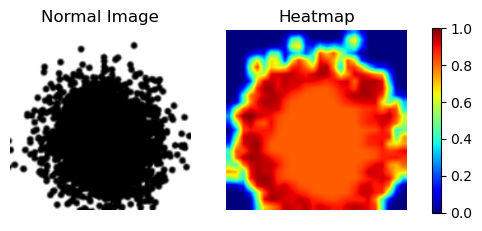

In [71]:
example_index = 300  # Try "1", "300"
example_image = X_train[example_index]
preprocessed_image = example_image.astype('float32') / 255.0

class_index = 0  # Index of the class for which you want to visualize the heatmap
heatmap = generate_grad_cam(model_one, preprocessed_image, class_index)

# Plot the original image, heatmap, and the superimposed image
fig, axs = plt.subplots(1, 2)
axs[0].imshow(example_image, cmap='gray')
axs[0].axis('off')
axs[0].set_title('Normal Image')
axs[1].imshow(heatmap, cmap='jet')
axs[1].axis('off')
axs[1].set_title('Heatmap')

plt.colorbar(plt.cm.ScalarMappable(cmap='jet'), ax=axs, shrink = 0.5)

plt.show()

In [72]:
heatmap

array([[0.97273475, 0.97273475, 0.97273475, ..., 0.97273475, 0.97273475,
        0.97273475],
       [0.97273475, 0.97273475, 0.97273475, ..., 0.97273475, 0.97273475,
        0.97273475],
       [0.97273475, 0.97273475, 0.97273475, ..., 0.97273475, 0.97273475,
        0.97273475],
       ...,
       [0.97273475, 0.97273475, 0.97273475, ..., 0.97273475, 0.97273475,
        0.97273475],
       [0.97273475, 0.97273475, 0.97273475, ..., 0.97273475, 0.97273475,
        0.97273475],
       [0.97273475, 0.97273475, 0.97273475, ..., 0.97273475, 0.97273475,
        0.97273475]], dtype=float32)

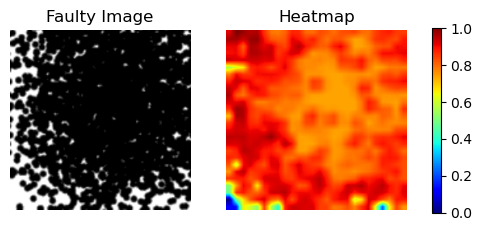

In [73]:
example_index = 1  # Try "1", "300"
example_image = X_train[example_index]
preprocessed_image = example_image.astype('float32') / 255.0

class_index = 0  # Index of the class for which you want to visualize the heatmap
heatmap = generate_grad_cam(model_one, preprocessed_image, class_index)

# Plot the original image, heatmap, and the superimposed image
fig, axs = plt.subplots(1, 2)
axs[0].imshow(example_image, cmap='gray')
axs[0].axis('off')
axs[0].set_title('Faulty Image')
axs[1].imshow(heatmap, cmap='jet')
axs[1].axis('off')
axs[1].set_title('Heatmap')

plt.colorbar(plt.cm.ScalarMappable(cmap='jet'), ax=axs, shrink = 0.5)

plt.show()